# Small Cell Network: Parametrized MDP- MatricizedModel

### Problem Setting:

The system consists of $n$ nodes which receive cellular traffic. the data packets are routed to a central destination tower via intermediate small cell towers which are $f$ in number. at any incident node or intermediate cell-tower, we can decide the next facility/cell-tower for the data-packet. the __cost__ incurred in the action is equal to the physical distance between the incident node/cell-tower to the assigned cell-tower. The objective is to minimize the expected routing cost from any node to the destination, via selection of a optimal policy (i.e assignment of next cell-tower/destination from any tower/node) and optimizing the placement of intermediate cell-towers (cell-tower locations (x, y coordinates) are the paramaters of the model to be optimized).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools;
import math;
import scipy.io as scio;
import copy;
import time;
import pickle;
from scipy.optimize import minimize;

n = 50; #number of initital nodes for data
f = 4; #number of resources/facilities/small-cell towers

V_VI = np.zeros((n+f+1));                                     #Initialisation of Value Function array for VI
V_new_VI = np.zeros((n+f+1));

V_MPI = np.zeros((n+f+1));                                     #Initialisation of Value Function array for MPI
V_new_MPI = np.zeros((n+f+1));

action = np.zeros((n+f+1));

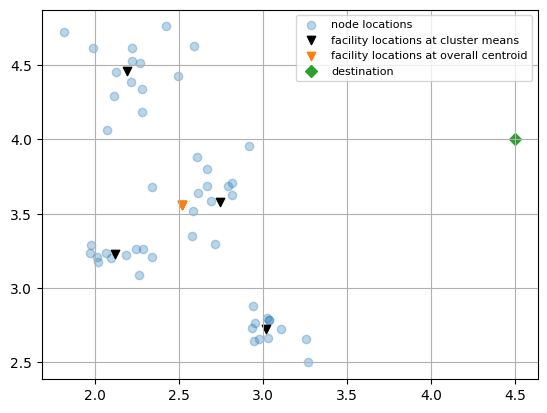

In [2]:
def createSmallCellNet(n, cov, k, scale, seed=None):
    # Generate random means for each cluster
    np.random.seed(seed)
    means = np.random.rand(k, 2)*scale
    # Generate random points in k clusters
    nodes = np.zeros((n, 2))
    for i in range(n):
        cluster = np.random.randint(0, k)  # Choose a random cluster
        nodes[i] = np.random.multivariate_normal(means[cluster], cov)
    # Y_s = np.tile(np.sum(nodes, axis=0), (k,1))/n + np.random.rand(k,2)*scale*0.05
    Ys_means = means + np.random.rand(k,2)*scale*0.0005
    Ys_centroid = np.tile(np.sum(nodes, axis=0),(k,1))/n + np.random.rand(k,2)*scale*0.0005
    dest = np.array([[0.9,0.8]])*scale #np.random.rand(1,2)*scale
    return nodes,Ys_means,Ys_centroid,dest

# Example usage 
n = 50 # Total number of points
scale = 5
var = 0.01e-1*scale**2 # variance of each cluster
cov = np.eye(2)*var # Covariance matrix
n_clusters = 4  # Total number of clusters
nodes, Ys_means, Ys_centroid, dest = createSmallCellNet(n, cov, n_clusters, scale, seed = 0)
plt.figure()
plt.scatter(nodes[:,0],nodes[:,1],marker='o',alpha=0.3)
plt.scatter(Ys_means[:,0],Ys_means[:,1],marker='v', color='black')
plt.scatter(Ys_centroid[:,0],Ys_centroid[:,1],marker='v')
plt.scatter(dest[:,0],dest[:,1],marker='D')
plt.grid()
plt.legend(['node locations',
            'facility locations at cluster means', 
            'facility locations at overall centroid', 
            'destination'], 
            fontsize=8)
plt.show()
smallCellNetdata = {'numNodes':n, 
                    'numFacilities':n_clusters, 
                    'nodeLocations':nodes, 
                    'cellLocations':Ys_centroid, 
                    'destinationLocation':dest}
filename = 'smallCellNetData.pkl'

with open(filename, 'wb') as file:
    pickle.dump(smallCellNetdata, file)


In [3]:
# # generate input datapoints
# M1 = 7 # number of facilities
# means1 = [np.array([-2,0]), 
#           np.array([5,10]), 
#           np.array([-2,-15]), 
#           np.array([15,10]), 
#           np.array([25,0])]#,
#         #   np.array([25,15]),
#         #   np.array([-5,15]), 
#         #   np.array([5,-5]),
#         #   np.array([20,-10]),
#         #   np.array([0,-7]),] # cluster means
# cov = 1
# covs1 = [np.array([[cov, 0],[0, cov]]),
#          np.array([[cov, 0],[0, cov]]),
#          np.array([[cov, 0],[0, cov]]),
#          np.array([[cov, 0],[0, cov]]),
#          np.array([[cov, 0],[0, cov]])]
#         #  ,
#         #  np.array([[cov, 0],[0, cov]]),
#         #  np.array([[cov, 0],[0, cov]]),
#         #  np.array([[cov, 0],[0, cov]]),
#         #  np.array([[cov, 0],[0, cov]]),
#         #  np.array([[cov, 0],[0, cov]])]
# split1 = np.array([11, 13, 9, 10, 10])#, 10, 10, 10, 10, 11]) # no of points in every cluster
# N1 = np.sum(split1) # total number of nodes
# X1 = np.zeros([N1,2]) # initialize datapoints
# X1_means = np.zeros([len(means1),2]) # initialize empirical mean of the clusters
# rho1 = np.ones(N1) # initialize the weights of the datapoints
# rho1 = rho1/len(rho1) # normalize
# cnt = 0
# np.random.seed(0);
# for i in range(len(means1)):
#     X1[cnt:cnt+split1[i], :] = np.random.multivariate_normal(means1[i], covs1[i], split1[i])
#     X1_means[i,:] = np.sum(X1[cnt:cnt+split1[i], :],axis=0)/split1[i]
#     cnt = cnt + split1[i]
# Y1_init = np.tile(np.sum(X1*rho1[:,np.newaxis], axis=0), (M1,1)) # initialize facility locations at the centroid of all the datapoints
# Z1 = np.array([[13,-3]])

# # plot data
# plt.scatter(X1[:,0],X1[:,1],marker='.')
# plt.scatter(Y1_init[:,0],Y1_init[:,1],marker='x')
# plt.scatter(Z1[0,0],Z1[0,1],marker='.')
# plt.grid()
# plt.legend(['node locations','initial cell locations'])
# plt.show()

# # save data
# smallCellNetdata = {'numNodes':N1, 'numFacilities':M1, 'nodeLocations':X1, 'cellLocations':Y1_init, 'destinationLocation':Z1}
# filename = 'smallCellNetData.pkl';

# with open(filename, 'wb') as file:
#     pickle.dump(smallCellNetdata, file)

# with open(filename, 'rb') as file:
#     data = pickle.load(file)



In [4]:
a = [1, 2, 3, 4];
expo = [np.exp(x) for x in a];
sum(expo);

# MDP model definition

### here we deifine the probability tranisiton model for the Small-cell optimization problem...

First we start with the definition of the state space for the model

from the problem defintion it is clear that the node, facility/cell-tower or destination location for the data-packet is the state of the system.

$s \in \{0\} := $ destination state

$s \in \{1, \ldots, f, f+1, \dots, 2f, \dots, \dots, f^2\} := $ cell-tower state

$s \in \{f^2+1,\ldots, n+f^2+1\} := $ node states

In [5]:
#define the state space and vectors here..
state_space = np.linspace(0, n+f*f, n+f*f+1, dtype = int)
state_space = [(s,) for s in state_space];
print(state_space)

[(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,), (19,), (20,), (21,), (22,), (23,), (24,), (25,), (26,), (27,), (28,), (29,), (30,), (31,), (32,), (33,), (34,), (35,), (36,), (37,), (38,), (39,), (40,), (41,), (42,), (43,), (44,), (45,), (46,), (47,), (48,), (49,), (50,), (51,), (52,), (53,), (54,), (55,), (56,), (57,), (58,), (59,), (60,), (61,), (62,), (63,), (64,), (65,), (66,)]


### Next we define the action space for the system.

Now for action space the definition is comparatively simple. Since we can control the next facility/cell-tower or destination that the data packet goes to (__not a node, only cell-towers or destination__), the action space is just the next fcell-tower/destination state index

$a \in \{0\} := $ goto destination

$a \in \{1, \ldots, f^2\} := $ goto cell-tower a


In [6]:
#define the action space of teh system...
act_space = np.linspace(0, f*f,f*f+1, dtype = int);
act_space = [(a,) for a in act_space];
print(act_space);

[(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,), (16,)]


In [7]:
act_mask = np.zeros(shape=(f*f+n+1, f*f+1));
# print(smallcell1.setState(3));
# act_mask[0, smallcell1.get_actions()] = 1;
# act_mask[0]

With the state and action spaces defined, we now move forward to defining the system model.

## System Model definition

For the system, the model is quite simple. The action represents the next cell-tower/destination ower for the packet to be routed from the present state of the system. The transition of the system from one state to another is deterministic, i.e. action of routing of a packet from one state to the next results in the packet to the routed to the destined next state w.p. 1.

The difficult part is the cost of the routing, the cost of routing from one state to the next is defined as the physical distance between the concerned points. For the model, the nodes, cell-tower and destination positions are considered to be two-dimensional datapoints in space, of which, the node and destination points fixed whereas the cell-tower coordinates are the parameters which must also be optimized.




In [8]:
#define the model here as a class
class SmallCellNet():

    #firstly define the data member for the model
    n: int; #number of nodes,
    f: int; #number of cell towers;
    nodeLocations: np.ndarray; #nx2 matrix including the node coordinates (fixed)
    cellLocations: np.ndarray; #fx2 matrix storing the cell-tower locations (changable)
    destinationLocation: np.ndarray; #1x2 matrix storing the destination location (fixed)#
    st:int;
    reward2cost:int;

    #define a probability transition matrix for the model.... (s,a) -> nextState
    P:np.ndarray;
    #define a cost function matrix for the transition (s,a) -> nextState
    C:np.ndarray;
    #define a gradient matrix wrt for each (s, a, s') for each parameters
    G:np.ndarray;
    #define a an action mask sxa dimensional matrix
    action_mask:np.ndarray;


    #define the constructor
    def __init__(self, locations_path:str, init_state=0):
        '''
        function initializes the small cell network model.
        n: number of starting nodes,
        f: number of intermediate cell-towers
        location_path: path to a mat file to get the node, destination and initialize the cell tower locations
        '''

        #now load the mat file from the path and get the locations
        with open(locations_path, 'rb') as datafile:
            data = pickle.load(datafile) 
        # data = scio.loadmat(locations_path);
        #get the params
        # para = data['para']; #using Amber's mat file of loactions for now.....TODO: Change this later to make more generic..
        #7th onwards are the nodes
        #firstly set the number of states, facilities to the mentioned values
        self.n = data['numNodes'];
        self.f = data['numFacilities'];
        self.nodeLocations = data['nodeLocations'];
        self.destinationLocation = data['destinationLocation'];
        self.st = init_state;
        self.init_params(); #initialize parameters through the function

        #fnally define the state and action space for the model
        self.state_space = [(s,) for s in np.linspace(0, self.n+self.f*self.f, self.n+self.f*self.f+1, dtype = int)];
        self.action_space = [(a,) for a in np.linspace(0, self.f*self.f, self.f*self.f+1, dtype = int)];

        #finally initialize the probability, cost, action mask and gradient tensors..
        self.init_state_distribution();
        self.init_probab_matrix();
        self.init_cost_matrix();
        self.init_action_mask();
        self.init_grad_matrix();

    # define a function to compute initial state distribution
    def init_state_distribution(self):
        ''' 
        function computes a distribution for initialization of states
        For FLPO, the support of the distribution is only on the nodal states
        '''
        rho = np.zeros(*self.state_space_shape());
        # uniform distribution over the nodal states
        rho[1+self.f**2:] = np.ones(self.n);
        self.rho = rho/np.sum(rho); # normalize

        pass;
    
    #define a function to initialize the probability transition
    def init_probab_matrix(self): ##Exclusive to the matricized version of the algorithm
        '''
        function initializes the probability transition matrix for matriced algorithms
        probability transition matrix is sxaxs dimensional tensor (3d tensor)
        '''
        #start with an initial zeros matrix
        #now for any state action pair, we must assign the corresponding probability of going to the next state
        #w.p 0.9 goto the state mentioned in the action
        self.P = np.tile(np.expand_dims(np.eye(*self.act_space_shape(),*self.state_space_shape()), axis=0), (*self.state_space_shape(),1,1));
        #and the destination gets an additional 0.1 probability....bcoz we goto destinaition with probability 0.1
        # self.P[:,:,0] += 0.1;
        pass;
    
    #define a function to initialize the cost matrix
    def init_cost_matrix(self):
        # initialize the cost matrix at very high cost for all state-action pairs
        C = 10000*np.ones(shape = (*self.state_space_shape(),*self.state_space_shape()))
        # compute lower dimensional cost matrix of the original FLPO problem as intermediate cost
        C_interm = np.sum(self.X**2, axis=1, keepdims=True) + np.sum(self.X**2, axis=1, keepdims=True).T - 2*(self.X @ self.X.T);
        # incentivize all transition from the facilities to destination;
        C_interm[1:self.f+1,0] -= 0;

        # pick sections of intermediate cost
        Cf2f = C_interm[1:self.f+1, 1:self.f+1]; # facilities to facilities
        Cf2d = C_interm[1:self.f+1, 0]; # facilities to destination
        Cn2f = C_interm[1+self.f:1+self.f+self.n, 1:1+self.f]; # nodes to facilities
        Cn2d = C_interm[1+self.f:, 0] # nodes to destination

        # now fill the higher dimensional cost matrix with the values of intermediate costs for allowable transitions
        for p in range(self.f+2):
            if p == 0:
                # from destination
                C[0,0] = 0; # to destination only
            elif p == 1:
                # from FLPO stage 1 facilities
                C[1:1+self.f, 0] = Cf2d; # to destination 
                C[1:1+self.f, 1+self.f:1+2*self.f] = Cf2f; # to FLPO stage 2 facilities
            elif p < self.f and p > 1:
                # from FLPO stage p facilities
                C[1+(p-1)*self.f:1+p*self.f, 0] = Cf2d # to destination
                C[1+(p-1)*self.f:1+p*self.f, 1+p*self.f:1+(p+1)*self.f] = Cf2f # to FLPO stage p+1 facilities
            elif p == self.f:
                # from FLPO final stage facilities
                C[1+(p-1)*self.f:1+p*self.f, 0] = Cf2d # to destination only
            elif p == self.f+1:
                # from FLPO nodes
                C[1+(p-1)*self.f:1+(p-1)*self.f+self.n, 1:1+self.f] = Cn2f # to facilities
                C[1+(p-1)*self.f:1+(p-1)*self.f+self.n, 0] = Cn2d # to destination

        # expand the cost matrix to define it for each action as well
        self.C = np.tile(np.expand_dims(C, axis=1), (1, *self.act_space_shape(), 1));
        pass;
    
    #define a function to update cost matrix..after change of parameters
    def update_cost_matrix(self):
        # initialize the cost matrix at very high cost for all state-action pairs
        C = 10000*np.ones(shape = (*self.state_space_shape(),*self.state_space_shape()))
        # compute lower dimensional cost matrix of the original FLPO problem as intermediate cost
        C_interm = np.sum(self.X**2, axis=1, keepdims=True) + np.sum(self.X**2, axis=1, keepdims=True).T - 2*(self.X @ self.X.T);
        # incentivize all transition from the facilities to destination;
        C_interm[1:self.f+1,0] -= 0;

        # pick sections of intermediate cost
        Cf2f = C_interm[1:self.f+1, 1:self.f+1]; # facilities to facilities
        Cf2d = C_interm[1:self.f+1, 0]; # facilities to destination
        Cn2f = C_interm[1+self.f:1+self.f+self.n, 1:1+self.f]; # nodes to facilities
        Cn2d = C_interm[1+self.f:, 0] # nodes to destination

        # now fill the higher dimensional cost matrix with the values of intermediate costs for allowable transitions
        for p in range(self.f+2):
            if p == 0:
                # from destination
                C[0,0] = 0; # to destination only
            elif p == 1:
                # from FLPO stage 1 facilities
                C[1:1+self.f, 0] = Cf2d; # to destination 
                C[1:1+self.f, 1+self.f:1+2*self.f] = Cf2f; # to FLPO stage 2 facilities
            elif p < self.f and p > 1:
                # from FLPO stage p facilities
                C[1+(p-1)*self.f:1+p*self.f, 0] = Cf2d # to destination
                C[1+(p-1)*self.f:1+p*self.f, 1+p*self.f:1+(p+1)*self.f] = Cf2f # to FLPO stage p+1 facilities
            elif p == self.f:
                # from FLPO final stage facilities
                C[1+(p-1)*self.f:1+p*self.f, 0] = Cf2d # to destination only
            elif p == self.f+1:
                # from FLPO nodes
                C[1+(p-1)*self.f:1+(p-1)*self.f+self.n, 1:1+self.f] = Cn2f # to facilities
                C[1+(p-1)*self.f:1+(p-1)*self.f+self.n, 0] = Cn2d # to destination

        # expand the cost matrix to define it for each action as well
        self.C = np.tile(np.expand_dims(C, axis=1), (1, *self.act_space_shape(), 1));
        pass;

    #define a function to iniitalize the gradient wrt parameters for each sxaxs combintation
    def init_grad_matrix(self):
        '''
        initialize the gradient w.r.t parameter tensor which is a state x action x nextState x parameter dimensional tensor..
        '''
        # initialize lower dimensional gradient matrix
        Gtemp = np.zeros(shape = (self.f+self.n+1, self.f+self.n+1, len(self.parameters())));
        # initialize higher dimensional gradient matrix
        G = np.zeros(shape = (*self.state_space_shape(), *self.state_space_shape(), len(self.parameters())));

        # fill up the values for the lower dimensional gradient matrix
        for p in range(self.f):
            Gtemp[p+1,:,2*p] = (self.X[p+1,0] - self.X[:,0])*2;
            Gtemp[p+1,:,(2*p)+1] = (self.X[p+1,1] - self.X[:,1])*2;
            Gtemp[:,p+1,2*p] = (self.X[p+1,0] - self.X[:,0])*2;
            Gtemp[:,p+1,(2*p)+1] = (self.X[p+1,1] - self.X[:,1])*2;
        Gd2f = Gtemp[0,1:self.f+1,:]; # destination to facilities 
        Gf2f = Gtemp[1:self.f+1,1:self.f+1,:]; # facilities to facilities
        Gf2n = Gtemp[1:self.f+1,self.f+1:,:]; # facilities to nodes
        Gf2d = Gtemp[1:self.f+1,0,:]; # facilities to destination
        Gn2f = Gtemp[self.f+1:,1:self.f+1,:]; # nodes to facilities

        G[0, 1:1+self.f*self.f, :] = np.tile(Gd2f, (self.f,1)); # destination 2 facilities
        G[1:1+self.f*self.f, 0, :] = np.tile(Gf2d, (self.f,1)); # facilities 2 destination
        G[1:1+self.f*self.f, 1:1+self.f*self.f,:] = np.tile(Gf2f, (self.f,self.f,1)); # facilities 2 facilities
        G[1:1+self.f*self.f, 1+self.f*self.f:,:] = np.tile(Gf2n, (self.f,1,1)); # facilities 2 nodes
        G[1+self.f*self.f:, 1:1+self.f*self.f,:] = np.tile(Gn2f, (1,self.f,1)); # nodes 2 facilities

        #now populate the required elements of the matrix
        self.G = np.tile(np.expand_dims(G, axis=1), (1, *self.act_space_shape(), 1, 1));
        pass;
    
    #define a function to update the gradient tensor
    def update_grad_matrix(self):
        '''
        Update the gradient w.r.t parameter tensor which is a state x action x nextState x parameter dimensional tensor..
        '''
        # initialize lower dimensional gradient matrix
        Gtemp = np.zeros(shape = (self.f+self.n+1, self.f+self.n+1, len(self.parameters())));
        # initialize higher dimensional gradient matrix
        G = np.zeros(shape = (*self.state_space_shape(), *self.state_space_shape(), len(self.parameters())));

        # fill up the values for the lower dimensional gradient matrix
        for p in range(self.f):
            Gtemp[p+1,:,2*p] = (self.X[p+1,0] - self.X[:,0])*2;
            Gtemp[p+1,:,(2*p)+1] = (self.X[p+1,1] - self.X[:,1])*2;
            Gtemp[:,p+1,2*p] = (self.X[p+1,0] - self.X[:,0])*2;
            Gtemp[:,p+1,(2*p)+1] = (self.X[p+1,1] - self.X[:,1])*2;
        Gd2f = Gtemp[0,1:self.f+1,:]; # destination to facilities 
        Gf2f = Gtemp[1:self.f+1,1:self.f+1,:]; # facilities to facilities
        Gf2n = Gtemp[1:self.f+1,self.f+1:,:]; # facilities to nodes
        Gf2d = Gtemp[1:self.f+1,0,:]; # facilities to destination
        Gn2f = Gtemp[self.f+1:,1:self.f+1,:]; # nodes to facilities

        G[0, 1:1+self.f*self.f, :] = np.tile(Gd2f, (self.f,1)); # destination 2 facilities
        G[1:1+self.f*self.f, 0, :] = np.tile(Gf2d, (self.f,1)); # facilities 2 destination
        G[1:1+self.f*self.f, 1:1+self.f*self.f,:] = np.tile(Gf2f, (self.f,self.f,1)); # facilities 2 facilities
        G[1:1+self.f*self.f, 1+self.f*self.f:,:] = np.tile(Gf2n, (self.f,1,1)); # facilities 2 nodes
        G[1+self.f*self.f:, 1:1+self.f*self.f,:] = np.tile(Gn2f, (1,self.f,1)); # nodes 2 facilities

        #now populate the required elements of the matrix
        self.G = np.tile(np.expand_dims(G, axis=1), (1, *self.act_space_shape(), 1, 1));
        pass;
    
    #define function to get the shape of hte state and action space
    def state_space_shape(self):
        return (self.n + self.f*self.f + 1,);
    
    #define a function to get the sacyion space dimensions
    def act_space_shape(self):
        return (self.f*self.f + 1,);
    
    #define a function to initialize the parameters for the model
    def init_params(self):
        #initialize the model parametrs to all zeros
        self.cellLocations = np.zeros(shape = (self.f, 2));
        self.X = np.vstack([self.destinationLocation, self.cellLocations, self.nodeLocations]);
        
        self.init_cost_matrix();
        self.init_grad_matrix();
        pass;
    
    #define a function to get the parameters for the model
    def parameters(self) -> np.ndarray:

        '''
        function returns a list of parameters for the system.
        '''

        #return the cell locations as the parameters list. each coordinate is a scalar parameter..
        return self.cellLocations.reshape(-1);
    
    #define a function to update the parameters to a new value
    def update_params(self, params: np.ndarray):
        '''
        function to update the list of paramaters for the model to a new set of parameters
        params: updated list f parameters of the same length and shape of elements as in self.parameters()
        return :
        None
        '''

        #firstly check if the number of parameters in the list match
        assert(params.shape == self.parameters().shape);

        #now go over each parameter in the list and update the corresponding model parameter
        # for i in range(len(params)):
        #     #assign the correspondin parameter after checking the dimension
        #     # in this case of small cell network every parameter element is a coordinate in the cellLocations matrix.
        #     # assert(params[i].shape == 1);
        #     self.cellLocations[int(i/2), i%2] = params[i];
        
        self.cellLocations = params.reshape(-1,2);

        #before updating the cost and gradient tensors...update the self.X vector with the updated parameters.
        self.X[1:self.f+1,:] = self.cellLocations;

        #once parameters are updated...update the cost and gradient tensors for the model..
        self.update_cost_matrix();
        self.update_grad_matrix();

        pass;
    
    #define a function to set the system state
    def setState(self, state):
        #just set the state
        assert((state <= self.n + self.f*self.f) & (state>=0));
        self.st = state;
        pass;
    
    def state(self):
        return (self.st,);
    
    #define a function to list the avaiable action for the state
    def get_actions(self):
        '''
        return:
        action_list: list of actions available for the present state of the system
        '''
        #here the action list is independent of the state that one is in, except for the the destination state, wherein the only
        # avaiable action is to stay there
        # print('state = ', self.st);
        test = self.action_space.copy();
        actions = [];
        if(self.st == 0):
            #only zero is the action possible at 0
            actions = [(0,)]
            print('actions = ', actions)
        elif((self.st>=1)&(self.st<1+self.f**2)):
            p = int((self.st-1)/self.f);
            print('p = ', p);
            if p == self.f-1:
                actions = [(0,)]
                print('actions = ', actions)
            else:
                actions = test[(p+1)*self.f+1:(p+2)*self.f+1]
                actions.remove((self.st+self.f,))
                print('actions = ', actions)
        elif((self.st>=1+self.f**2)&(self.st<=1+self.f**2+self.n)):
            actions = test[0:1+self.f]
            print('actions = ', actions)
        return actions
    
    #define a functino to define the action mask for the model....for matricized implementation
    def init_action_mask(self):
        ''' 
        Function to indicate allowable actions at every state
        '''
        self.action_mask = np.zeros(shape = (*self.state_space_shape(), *self.act_space_shape()));

        # allowable actions from destinations
        self.action_mask[0,0] = 1 # only destination is possible
        # allowable actions from nodes
        self.action_mask[self.f*self.f+1:, 0:self.f+1] = np.ones((self.n, 1+self.f)) # only stage 1 facility locations are possible
        # allowable actions from stage p to stage (p+1) facilities
        for p in range(1,self.f):
            #only stage p to stage p+1 allowed (no self hopping) for p < self.f
            self.action_mask[(p-1)*self.f+1:p*self.f+1, p*self.f+1:(p+1)*self.f+1] = np.ones((self.f,self.f)) - np.eye(self.f)
        self.action_mask[1:self.f*self.f+1,0] = 1 # destination allowed from all facilities in all stages

        pass;

    #next define the function to step from a given state to the using the actions and probabilities of arrival/departure events..
    # def step(self, act) -> list:

    #     '''
    #     act: action on the state to direct to the next state...,
        
    #     returns:
    #     state_prob_dict_array: an array dictionary of possible next states for the system, the corresponding reward and the
    #     associated probability of transition to those states. also a list with the gradient of the cost/reward w.r.t parameters (in same order as parameters) is returned
    #     if parameters are present else an empty list is returned.
    #     '''

    #     assert((act >= 0) & (act <= self.f));

    #     #the model is deterministic, hence the stepping action leads to one state w.p. 1

    #     #firstly check the whether the action can be performed
    #     if(self.st == 0):
    #         #the model is at terminal state, thus w.p. 1 the next state is the terminal state itself, cost is zero and
    #         # the gradient w.r.t parameters is also zero
    #         return [[(0,), 0, 1, [0]*(2*self.f)]];
        
    #     else:

    #         #now, there is actually some state transition and costs associated with the transition

    #         grads = [0]*(2*self.f);

    #         #the starting state is the present state, thus at the 
    #         prosp_state = act; #the action is the prospective state
    #         p = 0.9; #probablity 1
    #         #determine the cost at the squared 2-norm between the two point
    #         if(self.st >= self.f+1):
    #             pt1 = self.nodeLocations[self.st - self.f - 1, :];
    #             #no gradient wrt node location
    #             g1 = -1;
    #         elif((self.st >= 1)&(self.st <= self.f)):
    #             pt1 = self.cellLocations[self.st-1, :]; #a cell location is the present state
    #             #gradient w.r.t cell location is present
    #             g1 = self.st-1;
    #         else:
    #             pt1 = self.destinationLocation[0, :];
    #             g1 = -1;
            
    #         #same for next point..no check w.r.t node location because its not in the action space
    #         if((prosp_state >= 1)&(prosp_state <= self.f)):
    #             pt2 = self.cellLocations[prosp_state-1, :]; #a cell location is the next state
    #             #gradient w.r.t cell location is present
    #             g2 = prosp_state-1;
    #         else:
    #             pt2 = self.destinationLocation[0, :];
    #             g2 = -1;
            
    #         if(g1!=-1):
    #             grads[2*g1] = 2*(pt1[0] - pt2[0]); 
    #             grads[(2*g1)+1] = 2*(pt1[1] - pt2[1]);
    #         if(g2!=-1):
    #             grads[2*g2] = 2*(pt2[0] - pt1[0]); 
    #             grads[(2*g2)+1] = 2*(pt2[1] - pt1[1]);
            
    #         #and the cost is the euclidean norm
    #         cost = np.linalg.norm(pt1-pt2, 2)**2;
    #         if((prosp_state == 0)&(self.st >= 1)&((self.st <= self.f))):
    #             cost -= 50;

    #         state_prob_dict = [[(prosp_state,), cost, p, grads]];

    #         #with small probability.... goto destination
    #         grads = [0]*(2*self.f);

    #         #the starting state is the present state, thus at the 
    #         prosp_state = 0; #the action is the prospective state
    #         p = 0.1; #probablity 0.1
    #         #determine the cost at the squared 2-norm between the two point
    #         if(self.st >= self.f+1):
    #             pt1 = self.nodeLocations[self.st - self.f - 1, :];
    #             #no gradient wrt node location
    #             g1 = -1;
    #         elif((self.st >= 1)&(self.st <= self.f)):
    #             pt1 = self.cellLocations[self.st-1, :]; #a cell location is the present state
    #             #gradient w.r.t cell location is present
    #             g1 = self.st-1;
    #         else:
    #             pt1 = self.destinationLocation[0, :];
    #             g1 = -1;
            
    #         #same for next point..nothing doing, its the destination
    #         pt2 = self.destinationLocation[0, :];
    #         g2 = -1;
            
    #         if(g1!=-1):
    #             grads[2*g1] = 2*(pt1[0] - pt2[0]); 
    #             grads[(2*g1)+1] = 2*(pt1[1] - pt2[1]);
    #         if(g2!=-1):
    #             grads[2*g2] = 2*(pt2[0] - pt1[0]); 
    #             grads[(2*g2)+1] = 2*(pt2[1] - pt1[1]);
            
    #         #and the cost is the euclidean norm
    #         cost = np.linalg.norm(pt1-pt2, 2)**2;
    #         if((prosp_state == 0)&(self.st >= 1)&((self.st <= self.f))):
    #             cost -= 50;

    #         state_prob_dict.append([(prosp_state,), cost, p, grads]);

    #         return state_prob_dict;
        
    #define a function to step and execute the step to transition to next state using an action
    # def step_and_exec(self, act, deterministic_state:tuple = None):
    #     '''
    #     act: action to step and execute, i.e the next intended state to go to...,
    #     deterministic_state: tuple representing deterministic required transition to the specified next state. Default is None indicating no requirement

    #     returns:
    #     cost: The reward obtained on taking the action at the present state on the system
    #     '''

    #     #step using the required action to get the list of possible states and proobilities alongwith the reward
    #     state_probs = self.step(act); 
    #     # print(state_probs);
    #     #now check if deterministic transition is required...
    #     if(deterministic_state == None):
    #         #now using the prospective next states and their probabilities...pick a next state with the corresponding probability..
    #         [_, _, probs, _] = map(list, zip(*state_probs));
    #         # print(probs);
    #         state_next_index = np.random.choice(range(len(probs)), p=probs);
    #         # print(state_next_index);
    #         [state_next, cost, _, _] = state_probs[state_next_index];
    #         #before returning the reward, jump the state of the model to the next state..
    #         self.setState(*state_next);
    #     else:
    #         #require deterministic transition to next state...
    #         #so go ahead and get the next state... from the list of prospectives..
    #         [states, _ , _ ,_] = map(list, zip(*state_probs));
    #         #find the state in the list of states...
    #         state_next_index = states.index(deterministic_state);
    #         #get the cost associated to the the next state and set the next states
    #         [state_next, cost, _, _] = state_probs[state_next_index];
    #         #before returning the reward, jump the state of the model to the next state..
    #         self.setState(*state_next);

    #     #finally return the cost
    #     return cost;


In [9]:
smallcell1 = SmallCellNet('smallCellNetData.pkl');
print(smallcell1.X.shape)
# print(smallcell1.state())
print(smallcell1.state_space)
smallcell1.setState(0)
actions = smallcell1.get_actions()
print(actions);
# print(smallcell1.cellLocations[3]);
# print(smallcell1.step(1));
# smallcell1.init_probab_matrix();
# smallcell1.init_cost_matrix();
# smallcell1.init_action_mask();
# # print(np.sum(smallcell1.P, axis=-1));
# print('ss shape ',smallcell1.state_space_shape())
# print('as shape ',smallcell1.act_space_shape())
# print('C shape ',smallcell1.C.shape);
# print('P shape ',smallcell1.P.shape);
# print(smallcell1.action_mask.shape);
# print(smallcell1.rho)
# print(np.sum(smallcell1.rho))
# print(smallcell1.G[0,0,5])
# [cost, grads] = smallcell1.step_and_exec(1);
# print(cost);
# print(grads);
# print(smallcell1.state());

(55, 2)
[(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,), (19,), (20,), (21,), (22,), (23,), (24,), (25,), (26,), (27,), (28,), (29,), (30,), (31,), (32,), (33,), (34,), (35,), (36,), (37,), (38,), (39,), (40,), (41,), (42,), (43,), (44,), (45,), (46,), (47,), (48,), (49,), (50,), (51,), (52,), (53,), (54,), (55,), (56,), (57,), (58,), (59,), (60,), (61,), (62,), (63,), (64,), (65,), (66,)]
actions =  [(0,)]
[(0,)]


# Define the Optimizaton Routine.
With the GPU system model defined, we now define the optimization routines for the model using value and modified policy iteration.

## Q-function iteration with MEP (Known MDP)

Here we carry out the fixed point iterations for the optimal bellman operator obtained for optimal solution for MDP with maximized entropy. The objective of the optimization problem is to __minimize__ the expected discounted sum of costs over the trajectory through the policy, while maximizing the entopy of the state-action path. The resulting fixed point equation to be solved is as follows.

$ \Lambda_{\beta}(s,a) = (T\Lambda_{\beta})(s,a) $

where T is the optimal bellman operator, given as,

$ (T\Lambda_{\beta})(s,a) = \sum\limits_{s' \in \mathscr{S}} \left[ p_{ss'}^{a} \left( c_{ss'}^{a} + \frac{\gamma}{\beta}log(p_{ss'}^{a}) \right) \right] -\frac{\gamma^{2}}{\beta} \sum\limits_{s' \in \mathscr{S}} p_{ss'}^{a} log\left[ \sum\limits_{a' \in \mathscr{A}} exp\left\lbrace \frac{-\beta}{\gamma}\Lambda_{\beta}(s',a') \right\rbrace \right] $

Now, to account for actions that cannot be performed at a particular state, the above expression is augmented with the action mask $M(.,.)$ in all operations to eliminate the effect of prohibited actions based on states

$ (T\Lambda_{\beta})(s,a) = M(s, a) \left( \sum\limits_{s' \in \mathscr{S}} \left[ p_{ss'}^{a} \left( c_{ss'}^{a} + \frac{\gamma}{\beta}log(p_{ss'}^{a}) \right) \right] -\frac{\gamma^{2}}{\beta} \sum\limits_{s' \in \mathscr{S}} p_{ss'}^{a} log\left[ \sum\limits_{a' \in \mathscr{A}} M(s', a') exp\left\lbrace \frac{-\beta}{\gamma}\Lambda_{\beta}(s',a') \right\rbrace \right] \right) $

In [10]:
#define the Q iteration routine 
def QIteration(model:SmallCellNet, initValue:np.ndarray, gamma:float, beta:float, n_iters:int, allow_print = True, reward2cost:int=-1) -> list:

    '''
    params:
    model: The system model instance on whcih Q iteration is to be carried out.
    initValue: initial Assumption/estimate of the value function
    state space: state_space tensor (list) of the same diension as that of the value function.
    action_space: action space tensor(list) of for the acceptable action on the model
    gamma: Discount Factor for the rewards
    beta: entropy maximization weightage factor
    n_iters: number of iterations of value iteration optimization on the model.
    reward2cost: factor to specify reward/cost model. Use 1 for cost model and -1 for reward model. Default = -1
    return:
    finalValue: result of hte value iteration on the model.
    finalPolicy: optimized policy after value iteration on the model.
    train_params: evolution of parameters of concern during training iterations
    '''

    #start with the the value function and extract the dimensions of the states
    # assert(model.max_job1+1 == initValue.shape[0]); assert(model.max_job2+1 == initValue.shape[1]);
    # assert(initValue.shape[2] == 3); assert(initValue.shape[3] == 3); assert(initValue.shape[4] == 2);
    assert(initValue.shape ==  (*model.state_space_shape(), *model.act_space_shape()));

    #now go ahead and carry out the iterations of value iteration
    finalValue = initValue.copy();
    # action_mask = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()));
    # finalPolicy = np.zeros(shape=model.state_space_shape(), dtype=int);
    train_params = {};
    norm_diff = [];

    for iter in range(n_iters):

        prev_Val=finalValue.copy();

        #for each iteration...instead of the serialized approach....just get the probability transition tensor from the model and the cost tensor
        #also get the action mask tensor from the model for use in the policy determination
        #firstly get hold of the probability and cost tensors..and use that to compute the unsummed first term
        l = np.log(np.maximum(1e-8,model.P)); l[l == -np.inf]=0;
        term1 = model.P * ( model.C + (gamma/beta)*l); #this is the first term without summation over next states
        term1 = np.sum(term1, axis=tuple(-1*np.arange(1,len(model.state_space_shape())+1))); #summation over the next states...

        #now go ahead and compute the second term
        #for term 2 ...first compute the inner summation over next states and actions of the exponent of Q function
        tv = finalValue.copy(); tv[model.action_mask == 0] = np.inf;
        # me = np.min(tv, axis = 1, keepdims = True);
        me = np.min(tv, axis = tuple(-1*np.arange(1,len(model.act_space_shape())+1)), keepdims=True);
        e = model.action_mask * (finalValue - me); #Something to think atn....how can we offset better?
        term2 = model.action_mask * np.exp((-beta/gamma)*e);
        term2 = np.sum(term2, axis=tuple(-1*np.arange(1,len(model.act_space_shape())+1))); #summation over possible next actions
        term2 = np.log(term2) + (-beta/gamma)*np.squeeze(me, axis=1); #
        stateValueFunction = -gamma/beta * term2; # compute stateValue function iteratively on the way
        term2 = np.tensordot(model.P, term2, axes=len(model.state_space_shape())); #product with corresponding probability and summation over next states
        term2 = term2 * ((gamma**2) /beta); #coefficient multiplication..

        #now combine the terms...and mask out using the action mask..to get the updated Q function
        finalValue = model.action_mask * (term1 - term2);
        
        #repeat
        norm_diff.append(np.max(abs(finalValue - prev_Val)));
        norm = np.max(abs(finalValue));
        if(allow_print):
            print(f'iter: {iter} \t Delta Value(infinity Norm): {norm_diff[-1]}', end='\n');
        
        #finally check condition for convergence of optimal Q function and stop iteration if met
        if( norm_diff[-1]/norm < 1e-4):
            #condition met
            if(allow_print):
                print(f'\nPolicy and Params:\tfor Q, {norm_diff[-1]/norm} < 1e-3, Hence stopping QIteration');
            break;
    
    #finally after the iterations get the converged policy from the Q-function fixed point obtained..
    tv1 = finalValue.copy(); tv1[model.action_mask == 0] = np.inf;
    expo = np.exp((-beta/gamma) * (finalValue - np.min(tv1, axis= tuple(-1*np.arange(1,len(model.act_space_shape())+1)), keepdims=True))*model.action_mask)*model.action_mask ;#exponent of the q-function to get the final policy...
    sumexpo = np.sum(expo, axis=tuple(-1*np.arange(1,len(model.act_space_shape())+1)), keepdims= True);
    finalPolicy = expo/sumexpo;
    finalSumValue = np.sum(model.rho*stateValueFunction); # return the cumulative cost 
    
    train_params['norm_diff'] = norm_diff;
    #finally return the final value function and policy to the output
    return ([finalValue, finalPolicy, train_params, finalSumValue]);

### G-Iteration for parameter update

Here we define a function to perform bellman operator to determine the fixed point of the gradient of cost w.r.t parameters. The objective is to obtain the fixed point of the gradient bellman equation according to eq 24 in the paraMDP paper by amber srivastava.

The bellman operator for the action-dependent gradient function is as follows

$\left[TK_{\eta}^{\beta}\right](s, a) = \sum\limits_{s'} p_{ss'}^{a} \left[ \frac{\partial c_{ss'}^{a}}{\partial \eta} + \gamma G_{\eta}^{\beta}(s') \right]$

$ G_{\eta}^{\beta}(s) =  \sum\limits_{a \in \mathscr{A}} \mu(a|s) K_{\eta}^{\beta}(s,a) $

Thus,

$K_{\eta}^{\beta}(s, a) = \left[TK_{\eta}^{\beta}\right](s, a) $

$\implies  G_{\eta}^{\beta}(s) =  \sum\limits_{a \in \mathscr{A}} \mu(a|s) K_{\eta}^{\beta}(s,a) = \sum\limits_{a \in \mathscr{A}} \mu(a|s) \left[TK_{\eta}^{\beta}\right](s, a)$

$\therefore G_{\eta}^{\beta}(s) = \sum\limits_{a \in \mathscr{A}} \mu(a|s) \sum\limits_{s'} p_{ss'}^{a} \left[ \frac{\partial c_{ss'}^{a}}{\partial \eta} + \gamma G_{\eta}^{\beta}(s') \right] $



In [36]:
#define the G iteration routine
def GIteration(model:SmallCellNet, initValue:np.ndarray, policy:np.ndarray, gamma:float, beta:float, n_iters:int, allow_print = True, reward2cost:int=-1) -> list:

    '''
    function to determine the fixed point of the gradient function from the gradient bellman equation for each of the model parameters..
    params:
    model: The system model instance on whcih Q iteration is to be carried out.
    initValue: initial Assumption/estimate of the Gradient function (this is copied over for each model paramater)
    policy: Policy (probabilistic) on which the fixed point of the gradient vector is to be determined
    state space: state_space tensor (list) of the same diension as that of the value function.
    action_space: action space tensor(list) of for the acceptable action on the model
    gamma: Discount Factor for the rewards
    beta: entropy maximization weightage factor
    n_iters: number of iterations of value iteration optimization on the model.
    return:
    finalValue: list of the Gradient function for each of the model parameters,
    '''

    #start with the the value function and extract the dimensions of the states
    # assert(model.max_job1+1 == initValue.shape[0]); assert(model.max_job2+1 == initValue.shape[1]);
    # assert(initValue.shape[2] == 3); assert(initValue.shape[3] == 3); assert(initValue.shape[4] == 2);
    assert(model.parameters().shape != (0,));
    assert(initValue.shape ==  ( *model.state_space_shape(), model.parameters().shape[0] ));
    assert(policy.shape == (*model.state_space_shape(), *model.act_space_shape()));

    #now go ahead and carry out the iterations of value iteration
    train_params = {};
    norm_diff = [];
    finalValue = initValue;
    s = len(model.state_space_shape());
    sa = s + len(model.act_space_shape());
    sas = sa + len(model.state_space_shape());

    for iter in range(n_iters):

        prev_Val=finalValue.copy();
        
        #now implement the matricized version of the algorithm..
        #firstly get the next state and parameter G function and expand dimensions
        G_t = np.expand_dims(finalValue, axis= tuple(np.arange(0,sa)));
        #now get the gradient tensor from the model and combine it with the gradient function
        G_t = model.G + (gamma * G_t);
        #now combine it with the probability transition tensor...expanded dims to include parameters
        G_t = np.expand_dims(model.P,axis=-1) * G_t;
        #now summup over the next states...
        G_t = np.sum(G_t, axis= tuple(np.arange(sa, sas)));
        #noe combine with the policy by expanding policy dimensions to account for parameters axis
        G_t = np.expand_dims(policy, axis=-1) * G_t;
        #finally summup over the possible actions...
        finalValue = np.sum(G_t, axis= tuple(np.arange(s, sa)));
        
        #repeat
        norm_diff.append(np.max(abs(finalValue - prev_Val)));
        norm = np.max(abs(finalValue));
        if(allow_print):
            print(f'iter: {iter} \t Delta Value(infinity Norm): {norm_diff[-1]}', end='\r');
        
        #finally check condition for convergence of optimal Q function and stop iteration if met
        if( norm_diff[-1]/norm < 1e-4):
            #condition met
            if(allow_print):
                print(f'\nPolicy and Params:\tfor G, {norm_diff[-1]/norm} < 1e-3, Hence stopping GIteration');
            break;
    
    train_params['norm_diff'] = norm_diff;
    #finally return the final value function and policy to the output
    return ([finalValue, train_params]);

## Parameter update via gradient decent

Now we define a routine to optimize the paramaters via gradient decent

The parameters are optimized using gradient decent where the gradient w.r.t parameters is obtained as the fixed point solution of GIteration for the latest updated value of the parameters. Hence the slgorithm of determning the optimal parameters for the given policy consists of the following steps:

Until Convergence

1. for parameter estimates $\eta_{k}$ and given policy, obtain the fixed point of the gradient bellman equation $G_{\eta_{k}}^{\beta}$ using GIteration

2. Update parameter values using gradient descent

$ \eta_{k+1} = \eta_{k} - \epsilon_{k} \sum\limits_{s\in\mathscr{S}} G_{\eta_{k}}^{\beta}(s) $

3. $k \leftarrow k+1$

In [37]:
# define an explicit function that computes value function as a function of parameters
def valueFunction(model:SmallCellNet, x, GInit, Q, gamma:float, beta:float, n_iters:int, allow_print = False, reward2cost:int=-1):
    ''' 
    x : 1D array of unknown parameters
    '''
    model.update_params(x);
    [finalVal, finalPol, train_params, finalValue] = QIteration(smallcell1, Q, gamma=gamma, beta=beta, n_iters=n_iters, allow_print=False, reward2cost=1);
    [G, _] = GIteration(model, GInit, finalPol, gamma, beta, n_iters, False, reward2cost);
    dfinalValue = np.sum(model.rho[:,None]*G, axis=0);
    # sum G along the states
    return (finalValue, dfinalValue)

In [38]:
#define parameter gradient descent optimization routine here
def optimizeParams(model:SmallCellNet, initValue:np.ndarray, policy:np.ndarray, gamma:float, beta:float, epsilon:float, n_iters:int, gd_iters:int, allow_print = True, reward2cost:int=-1) -> dict:

    '''
    Function performs gradient descent optimization for the parameters of the model for a fixed policy by determination of gradient fixed points
    params:
    model: The system model instance on whcih Q iteration is to be carried out.
    initValue: initial Assumption/estimate of the Gradient function
    policy: Policy (probabilistic) on which the fixed point of the gradient vector is to be determined
    state_space: state_space tensor (list) of the same dimension as that of the value function.
    action_space: action space tensor(list) of for the acceptable action on the model
    gamma: Discount Factor for the rewards
    beta: entropy maximization weightage factor
    epsilon: learning rate for gradient descent
    n_iters: number of iterations of gradient fixed point iteration on the model.
    gd_iters: number of gradient descent iterations
    reward2cost: conversion factor for conversion of reward model to cost model (-1 for reward model, 1 for cost model) >Default = -1
    '''

    #firstly get the lis of model parameters and assert if there are model parameters to optimize
    assert(model.parameters().shape != (0,));

    train_params = {};
    norm_diff = [];
    norm= [] 
    lmd_k = 0; # initialize sequence for Nesterov's Gradient Descent
    lmd_k1 = 0;
    c_k = 0; # initialize sequence for Nesterov's Gradient Descent
    y_k = 0; # initialize the current momentum vector
    y_k1 = 0; # initialize the future momentum vector

    #now just start the gradient descent iterations
    G_prev = initValue;
    for iter in range(gd_iters):

        #in each iteration, compute the fixed point of the gradient using GIteration for the present value of the parameters
        [G, _]= GIteration(model, G_prev, policy, gamma, beta, n_iters, False, reward2cost);

        #now once the gradient is obtained w.r.rt each parameter in the model..time to update the parameters of the model
        #get the list of parameters first
        params = model.parameters();

        # use an optimizer to solve for params
        # method : BFGS 
        # V = lambda x : valueFunction(model, x, G, state_space=state_space, action_space=action_space,gamma=gamma, beta=beta, n_iters=n_iters, allow_print=False, reward2cost=1);
        # res = minimize(V, params, method='BFGS', jac=True, options={'xtol': 1e-8});
        # params = res['x'];

        # Nesterov's Gradient Descent Iterations here
        # update lmd sequence
        lmd_k1 = (1+np.sqrt(1+4*lmd_k**2))/2;
        # update c sequence
        c_k = (1-lmd_k)/lmd_k1;
        y_k1 = params - epsilon*np.sum(G, axis = tuple(np.arange(0,len(model.state_space_shape()))));
        params = (1-c_k)*y_k1 + c_k*y_k;
        y_k = y_k1;
        lmd_k = lmd_k1;

        #now loop through the model parameters and update the list elements individually
        # params =  params - epsilon*np.sum(G, axis = tuple(np.arange(0,len(model.state_space_shape()))) );
        # params = np.array([ params[i] - epsilon*np.sum(G[..., i]) for i in range(params.shape[0])]);

        #finally update the parameters in the model
        model.update_params(params);

        #print the norms for reference
        norm_diff.append(np.max(abs(G - G_prev)));
        norm.append(np.max(abs(np.sum(G, axis = tuple(np.arange(0,len(model.state_space_shape())))))));
        # norm.append(np.max(abs(G)));
        G_prev = G.copy();
        if(allow_print):
            print(f'iter: {iter} \t Delta Value(infinity Norm): {norm_diff[-1]} \t Infinity Norm: {norm[-1]}', end='\r');
        
        #finally check condition for convergence of optimal Q function and stop iteration if met
        if( norm[-1] < 0.01):
            #condition met
            if(allow_print):
                print(f'\nPolicy and Params:\tfor GD, {norm[-1]} < 0.01, Hence stopping Gradient Descent Iteration');
            break;
    
    train_params['norm_diff'] = norm_diff;
    train_params['norm'] = norm;

    return [G, train_params];


## Policy+Paramater Optimization

Now, we define a routine to carry out policy and parameter optimization for the model in an alternating fashion, i.e we carry out the following steps

Until Convergence

1. Fixing the model parameters for a given $\beta$ determine the optimal policy using QIteration

2. Fixing the updated policy, optimize parameters using gradient descent.

In [64]:
#define the policy and parameteroptimization routine here..
def optimizePolicyNParams(model:SmallCellNet, gamma:float, beta:float, epsilon:float, n_iters:int, n_iters_qi:int, gd_iters:int, n_iters_gi:int, allow_print = True, reward2cost:int=-1, aux_params:dict=None):
    '''
    function to optimize the poliy and parameters via alternating QIteration and parameter optimization via GIteration
    params:
    model: The system model instance on whcih Q iteration is to be carried out.
    gamma: Discount Factor for the rewards
    beta: entropy maximization weightage factor
    epsilon: learning rate for gradient descent
    n_iters: number of iterations of gradient fixed point iteration on the model.
    n_iters_qi:
    gd_iters: number of gradient descent iterations
    n_iters_gi:
    reward2cost: conversion factor for conversion of reward model to cost model (-1 for reward model, 1 for cost model) >Default = -1
    return:
    finalPol: Optimal Policy
    train_params: training parameters for debugging
    '''

    train_params ={};
    norm_diff = [];
    norm = [];
    normG = [];

    #go ahead and directly start the alternating optimization iterations
    if(aux_params != None):
        Q_prev = aux_params['Q'];
        V_GI = aux_params['G'];
    else:
        Q_prev = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()))
        # V_QI = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()));
        V_GI = np.zeros(shape = (*model.state_space_shape(), model.parameters().shape[0]));
    
    for iter in range(n_iters):

        #for each iterations, firstly,  for the present model parametrs and the given beta..
        #to do so initialize the Q_iteration estimate
        [Q, finalPol, train_params_Q, _] = QIteration(smallcell1, Q_prev, gamma=gamma, beta=beta, n_iters=n_iters_qi, allow_print=False, reward2cost=reward2cost);
        [V_GI, _]= GIteration(smallcell1, V_GI, finalPol, gamma, beta, n_iters, False, reward2cost);
        #with the optimal policy for given parameters and beta determined using QIteration, now we optimize parameters for the given polcy and beta
        # [V_GI, train_params_P] = optimizeParams(smallcell1, V_GI, finalPol, model.state_space, model.action_space, gamma=gamma, beta=beta, epsilon=epsilon,
        # n_iters = n_iters_gi, gd_iters= gd_iters, allow_print=False, reward2cost=reward2cost);
        V = lambda x : valueFunction(model, x, V_GI, Q, gamma=gamma, beta=beta, n_iters=n_iters, allow_print=False, reward2cost=1);
        params = model.parameters();
        res = minimize(V, params, method='BFGS', jac=True);
        params = res.x;
        grad = res.jac;
        model.update_params(params);

        norm_diff.append(np.max(abs(Q - Q_prev)));
        norm.append(np.max(abs(Q)));
        normG.append(np.max(abs(grad)));
        Q_prev = Q.copy();
        if(allow_print):
            print(f'iter: {iter} \t Delta Q Value(infinity Norm): {norm_diff[-1]} \t Q-Infinity Norm: {norm[-1]} \t G-Infinity Norm: {normG[-1]}', end='\r');
        
        #finally check condition for convergence of optimal Q function and stop iteration if met
        if( norm_diff[-1]/norm[-1] < 1e-4):
            #condition met
            if(allow_print):
                print(f'\nPolicy and Params:\tfor Q, {norm_diff[-1]/norm[-1]} < 1e-3 \t for G, {normG[-1]} < 1, Hence stopping Iteration');
            break;
        
    #finally return the optimal converged policy and the training parameters, optimized model parameters have already been updated on the model
    train_params['norm_diff'] = norm_diff;
    train_params['norm'] = norm;
    train_params['Q'] = Q;
    train_params['G'] = V_GI;

    return [finalPol, train_params];


## Annealed Policy+Parameter Optimization

We now define the routine to optimize the policy with parameters while annealing the inverse temperature beta

The algorithm is as follows;

1. initialize $\beta : = \beta_{init}$

2. while $\beta < \beta_{max}$

    a. optimize policy and parameters for $\beta$.

    b. perturb resulting optimal paramaters by i.i.d. random variables $\mathscr{N}(0, \sigma)$.

    c. $\beta \leftarrow \beta \times $ factor, where factor $> 1$.


In [65]:
##define a routine for annealed optimization here
def optimizePolicyNParams_annealed(model:SmallCellNet, gamma:float, beta_init:float, beta_max:float, beta_grow:float, sigma:float, epsilon:float, n_iters:int, n_iters_qi:int, gd_iters:int, n_iters_gi:int, allow_print = True, reward2cost:int=-1):
    '''
    function to optimize the poliy and parameters via alternating QIteration and parameter optimization via GIteration
    params:
    model: The system model instance on whcih Q iteration is to be carried out.
    gamma: Discount Factor for the rewards
    beta_init: Initial entropy maximization weightage factor
    beta_max: Maximum entropy maximization weightage factor
    beta_grow: growth factor for beta
    sigma: perturbation standard deviation
    epsilon: learning rate for gradient descent
    n_iters: number of iterations of gradient fixed point iteration on the model.
    n_iters_qi:
    gd_iters: number of gradient descent iterations
    n_iters_gi:
    reward2cost: conversion factor for conversion of reward model to cost model (-1 for reward model, 1 for cost model) >Default = -1
    return:
    finalPol: Optimal Policy
    '''

    #direstly go ahead and start the iterations
    beta = beta_init; #initilize annealing temperature to initial value
    #start the iterations
    Q = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()))
    # V_QI = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()));
    G = np.zeros(shape = (*model.state_space_shape(), model.parameters().shape[0]));

    while beta < beta_max:

        if(allow_print):
            print(f'@beta = {beta}');

        #determine the optimal policy and parameters for the given beta
        [finalPol, train_params] = optimizePolicyNParams(model, gamma = gamma, beta = beta, epsilon=epsilon, n_iters=n_iters,
        n_iters_qi=n_iters_qi, gd_iters=gd_iters, n_iters_gi=n_iters_gi, allow_print=allow_print, reward2cost=reward2cost,
        aux_params={'Q': Q, 'G': G});

        Q = train_params['Q'];
        G = train_params['G'];

        #with the optimal policy and optimal parameters determined perturb the optimal parameters for optimization at next beta
        #get the model parameters
        params = model.parameters();
        #go through each parameter and add a perturbation to its value
        # params = [params[i] + np.random.randn()*sigma for i in range(len(params))];
        params = params + np.random.randn(*params.shape)*sigma;
        #apply yht updated parameters to the model
        model.update_params(params);

        #finally update the beta for next iteration
        beta = beta*beta_grow;
    
    #finally return the optimal policy
    return finalPol;

### Function for plotting results

In [66]:
def getRoutes(model:SmallCellNet, fp):
    routes = np.zeros((model.n,model.f+1))
    for p in range(model.f+1):
        if p == 0: # from nodes
            goto_array = list(np.argmax(fp[1+model.f*model.f:], axis=1));
            routes[:,p] = np.array(goto_array)
        else:
            # find facilities to go in stage 2
            goto_array_temp = list(np.argmax(fp[goto_array], axis=1));
            routes[:,p] = np.array(goto_array_temp)
            goto_array = goto_array_temp;
    return routes;

def plotRoutes(model:SmallCellNet, fp, title):
    # plot the nodepoints first
    plt.figure(figsize=(5,5));
    plt.scatter(model.nodeLocations[:, 0], model.nodeLocations[:, 1], color='green', label='User Nodes');
    plt.scatter(model.cellLocations[:, 0], model.cellLocations[:, 1], marker = '^', color='black', label='Cell Towers');
    plt.scatter(model.destinationLocation[:, 0], model.destinationLocation[:, 1], marker = '*', color='red', label='Dest.');
    plt.xlabel(r'X');
    plt.ylabel(r'Y');
    plt.legend();
    labels = list(range(1+model.f+model.n));

    # for i in range(1+model.f+model.n):
    #     plt.annotate(labels[i], (model.X[i,0], model.X[i,1]), textcoords="offset points", xytext=(0,1), ha='center', fontsize=8)
    
    D = 0;
    options = ['-', '--', '-.', ':',]

    routes = getRoutes(model, fp);

    for n in range(model.n):
        st = n;
        id_st_X = st + model.f + 1;
        for k in range(model.f+1):
            nst = routes[n][k]
            if nst != 0:
                line_style = np.random.choice(options);
                color = np.random.rand(3);
                id_nst_X = int((nst-1)%model.f) + 1;
                # print(id_nst_X)
                plt.plot([model.X[id_st_X,0], model.X[id_nst_X, 0]],
                         [model.X[id_st_X,1], model.X[id_nst_X, 1]],
                         color=color,linewidth=1.5,linestyle=line_style);
                D = D + np.sum((model.X[id_st_X] - model.X[id_nst_X])**2);
                st = nst;
                id_st_X = id_nst_X;
            elif nst == 0:
                line_style = np.random.choice(options);
                color = np.random.rand(3);
                id_nst_X = 0
                plt.plot([model.X[id_st_X,0], model.X[id_nst_X, 0]],
                         [model.X[id_st_X,1], model.X[id_nst_X, 1]],
                         color=color,linewidth=1.5,linestyle=line_style)
                D = D + np.sum((model.X[id_st_X] - model.X[id_nst_X])**2);
                st = nst;
                id_st_X = id_nst_X;

    plt.gca().set_aspect('equal')
    plt.grid();
    plt.title(r'Infinite-Horizon Time Invariant Implementation');
    plt.show()

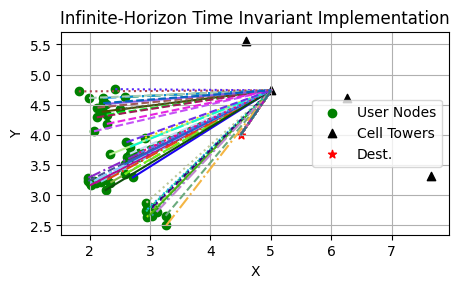

In [67]:
# plotPolicy(smallcell1, np.zeros(shape=(*smallcell1.state_space_shape(), *smallcell1.act_space_shape())), 'testing')
fptest = np.zeros(shape=(*smallcell1.state_space_shape(), *smallcell1.act_space_shape()));
fptest[1+smallcell1.f**2:1+smallcell1.f**2+smallcell1.n, 1] = np.ones(smallcell1.n); # all nodes to facility 1
fptest[0:1+smallcell1.f**2,0] = np.ones(1+smallcell1.f**2); # all facilities to destination
routes = getRoutes(smallcell1, fptest);
plotRoutes(smallcell1, fptest, 'test');

## Value and Modified Policy Iteration over array of dicount Factors (REFERENCE RESULTS FOR __Question 2.__)

Try out Q-iteration for one of the discount factors

Also loop over the betas and see effect of increasing beta..

In [68]:
smallcell1 = SmallCellNet("smallCellNetData.pkl");
# print(smallcell1.state())
# smallcell1.setState(1)
print(smallcell1.cellLocations[3]);
# print(smallcell1.step(0))

[0. 0.]


In [69]:
verificationParams = np.array([5.007172447314836, 4.739229358920149, 4.583635987485419, 5.560810885490961, 7.654917383332541, 3.317342581767660,
6.267291265380822, 4.612761646327473]) #, 4.078552812091590, 4.005094924238611, 5.8, 9.2, 9.3, 1.2])#, 5.007172447314836])#, 4.739229358920149, 4.583635987485419, 5.560810885490961, 7.654917383332541, 3.317342581767660,
# 6.267291265380822, 4.612761646327473, 4.078552812091590, 4.005094924238611]);
smallcell1.update_params(params=verificationParams);
smallcell1.parameters();
smallcell1.update_cost_matrix();
smallcell1.update_grad_matrix();

# print('parameters = ', smallcell1.parameters());
# print('cost matrix = ', smallcell1.C[1,smallcell1.f+2]);
print('grad matrix = ', smallcell1.G[2,2,5]);

grad matrix =  [ 0.84707292 -1.64316305 -0.84707292  1.64316305  0.          0.
  0.          0.        ]


In [45]:
smallcell1.C[4, 0, 0]
smallcell1.G[4, 0 ,0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 3.53458253, 1.22552329])

In [46]:
import time;

In [70]:
V_QI = np.zeros(shape = (*smallcell1.state_space_shape(), *smallcell1.act_space_shape()));
beta_array = [0.001]; # [0.1, 1, 2, 4, 8, 10];
for bet in beta_array:
    st = time.time();
    [finalVal, finalPol, train_params, finalValue] = QIteration(smallcell1, V_QI, gamma=0.9, beta=bet, n_iters=201, allow_print=True, reward2cost=1);
    print(f'Execution Time: {time.time() - st} seconds');
    pol_det = (finalPol > 0.5)*1; #make the NPG policy deterministic by determining action as 1 if the probability is greater than 1
    # plotResults(pol_det, title=f'Final Policy, $\\beta$ = {bet}');

print(V_QI.shape)
# finalVal.shape


iter: 0 	 Delta Value(infinity Norm): 1122.0440531695042
iter: 1 	 Delta Value(infinity Norm): 848.9105464785989
iter: 2 	 Delta Value(infinity Norm): 718.7726019612408
iter: 3 	 Delta Value(infinity Norm): 3.6383214931356633
iter: 4 	 Delta Value(infinity Norm): 1.9036880307548927
iter: 5 	 Delta Value(infinity Norm): 0.0

Policy and Params:	for Q, 0.0 < 1e-3, Hence stopping QIteration
Execution Time: 0.017549991607666016 seconds
(67, 17)


In [48]:
# print('value function = ', stateValueFunction)

## G Iteration to determine fixed point of gradient

Now, next apply GIteration on the mode, with the optimal policy obtained, to determine the fixed point of the gradient bellman equation for each parameter

In [51]:
#initializae the initial value for the GIteration
V_GI = np.zeros((smallcell1.n+smallcell1.f*smallcell1.f+1, smallcell1.f*2));
st = time.time();
[finalGVal, train_params] = GIteration(smallcell1, V_GI, finalPol, gamma=0.75, beta = 0.001011,
n_iters = 500, allow_print=True, reward2cost=1);
print(f'Execution Time: {time.time() - st} seconds');
# print('finalGVal shape = ', np.shape(finalGVal));
# print('finalGVal = \n' , finalGVal);
# print('finalGVal = \n' , finalGVal[1+smallcell1.f]);

iter: 5 	 Delta Value(infinity Norm): 0.02156890245234315
Policy and Params:	for G, 0.0 < 1e-3, Hence stopping GIteration
Execution Time: 0.02129673957824707 seconds


In [52]:
smallcell1.G

array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 1.01434489,  1.47845872,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.16727197, ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 1.01434489,  1.47845872,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.16727197, ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        

In [53]:
finalGVal[...,0]

array([ 0.        , -3.07067262, -1.05316376, -2.66505415, -1.93931765,
       -2.28319949, -0.4350364 , -1.95607618, -1.27105986, -1.47034902,
        0.40512539, -1.13511373, -0.44175455,  1.01434489,  0.        ,
        0.        ,  0.        , -0.47456756, -0.40983133, -0.58643076,
       -0.5230362 , -0.28691679, -0.59416001, -0.57346137, -0.28561893,
       -0.25527514, -0.46159156, -0.59102856, -0.63599504, -0.23935801,
       -0.22222912, -0.17217401, -0.40519393, -0.63262985, -0.1637169 ,
       -0.14967709, -0.10361755, -0.6351327 , -0.20849021, -0.17842541,
       -0.12448783, -0.36362993, -0.12121357, -0.26004576, -0.10274377,
       -0.60616734, -0.4215259 , -0.44895992, -0.15001768, -0.40898201,
       -0.24828886, -0.74583969, -0.32591661, -0.51333627, -0.5251926 ,
       -0.45005114, -0.22456971, -0.63059031, -0.67173247, -0.75081911,
       -0.10719883, -0.24974711, -0.25650976, -0.58420477, -0.41944522,
       -0.02226356, -0.2257802 ])

In [54]:
np.sum(finalGVal, axis=0)

array([ -35.04914507,   62.16148035, -102.6398595 ,  193.88754356,
        384.80326723, -164.46415422,  167.03546294,   41.85987823])

## Parameter update via gradient decent

Now we apply the parameter optimization routine on the model to optimize the parameters for the fixed optimal policy at the given beta

In [55]:
st = time.time()
train_params = optimizeParams(smallcell1, V_GI, finalPol, gamma=0.9, beta = 0.001011, epsilon=0.001,
n_iters = 500, gd_iters= 200, allow_print=True, reward2cost=1);
print(f'Execution Time: {time.time() - st} seconds');

iter: 101 	 Delta Value(infinity Norm): 0.0023794107339689674 	 Infinity Norm: 0.005330249176294988
Policy and Params:	for GD, 0.005330249176294988 < 0.01, Hence stopping Gradient Descent Iteration
Execution Time: 1.6532671451568604 seconds


In [56]:
smallcell1.parameters()

array([3.50056289, 3.77817922, 3.50043003, 3.77827572, 3.50209951,
       3.77822133, 3.50128986, 3.7782659 ])

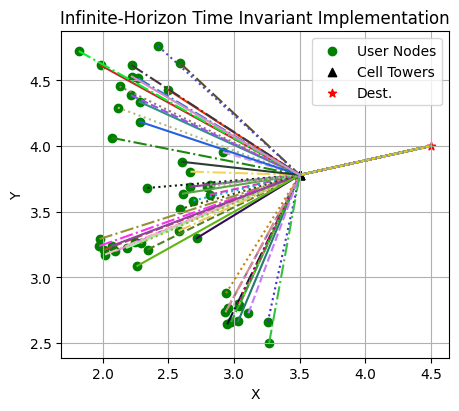

In [57]:
plotRoutes(smallcell1, finalPol, 'test');

## Combined Optimization of policy and parameters

Now we apply the parameter and policy optimization routine to obtain combined optimal result for policy and parameters for a given beta

In [58]:
smallcell1.init_params();
smallcell1.init_cost_matrix();
smallcell1.init_grad_matrix();
smallcell1.init_action_mask();
smallcell1.parameters();

In [59]:
smallcell1.G[4,0,0];

In [60]:
verificationParams = np.array([5.007172447314836, 4.739229358920149, 4.583635987485419, 5.560810885490961, 7.654917383332541, 3.317342581767660,
6.267291265380822, 4.612761646327473]) #, 4.078552812091590, 4.005094924238611])#, 5.007172447314836, 4.739229358920149, 4.583635987485419, 5.560810885490961, 7.654917383332541, 3.317342581767660,
# 6.267291265380822, 4.612761646327473, 4.078552812091590, 4.005094924238611]);
smallcell1.update_params(params=verificationParams);
smallcell1.parameters();

In [61]:
[finalPol, train_params] = optimizePolicyNParams(smallcell1, gamma = 0.9, beta = 0.00001, epsilon=0.001, n_iters=50,
n_iters_qi=201, gd_iters=200, n_iters_gi=500, allow_print=True, reward2cost=1);

iter: 1 	 Delta Q Value(infinity Norm): 1.91393596137641 	 Q-Infinity Norm: 269632.58640086954 	 G-Infinity Norm: 8.439839997124224
Policy and Params:	for Q, 7.0983110273285486e-06 < 1e-3 	 for G, 8.439839997124224 < 1, Hence stopping Iteration


In [62]:
smallcell1.parameters();

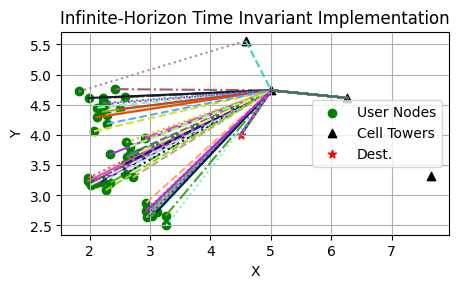

In [63]:
plotRoutes(smallcell1, finalPol, 'test');

## Annealed Combined optimization of Policy and Parameters

Finally we carry out combined optimizaition of policy and parameters while annealing the inverse temperature

In [71]:
smallcell1.init_params();
smallcell1.init_cost_matrix();
smallcell1.init_grad_matrix();
smallcell1.init_action_mask();
smallcell1.parameters();

In [72]:
smallcell1.G[4,0,0];

0.001011

In [73]:
finalPol = optimizePolicyNParams_annealed(smallcell1, gamma = 0.9, beta_init = 0.000001, beta_max=100, beta_grow=2.5, sigma=0.05,
epsilon=0.0005, n_iters=50, n_iters_qi=201, gd_iters=200, n_iters_gi=500, allow_print=True, reward2cost=1);

@beta = 1e-06
iter: 1 	 Delta Q Value(infinity Norm): 15.696241930127144 	 Q-Infinity Norm: 2696468.532384025 	 G-Infinity Norm: 3.1277214616627953
Policy and Params:	for Q, 5.821036567502476e-06 < 1e-3 	 for G, 3.1277214616627953 < 1, Hence stopping Iteration
@beta = 2.4999999999999998e-06
iter: 1 	 Delta Q Value(infinity Norm): 0.200378708075732 	 Q-Infinity Norm: 1078563.662388202 	 G-Infinity Norm: 3.249910517686869
Policy and Params:	for Q, 1.8578292136418247e-07 < 1e-3 	 for G, 3.249910517686869 < 1, Hence stopping Iteration
@beta = 6.2499999999999995e-06
iter: 1 	 Delta Q Value(infinity Norm): 0.1689132809988223 	 Q-Infinity Norm: 431401.4592278706 	 G-Infinity Norm: 3.4135201879492376
Policy and Params:	for Q, 3.9154545582934755e-07 < 1e-3 	 for G, 3.4135201879492376 < 1, Hence stopping Iteration
@beta = 1.5625e-05
iter: 1 	 Delta Q Value(infinity Norm): 0.14138465104042552 	 Q-Infinity Norm: 172537.23728645133 	 G-Infinity Norm: 3.386873981221056
Policy and Params:	for Q, 8.19

In [74]:
print(smallcell1.parameters())
for i in range(len(finalPol)):
    print(i, ' ', finalPol[i])
# print(finalPol[5])

[3.5783566  3.65437399 3.19021665 3.59567735 3.97076593 3.73979167
 2.7245443  3.73546874]
0   [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1   [3.25089938e-23 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.23364712e-11 1.00000000e+00
 1.68799492e-58 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
2   [1.14202414e-61 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 5.24254141e-20
 1.74852748e-30 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
3   [1.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 1.08007565e-016 6.98533105e-047 0.00000000e+000
 7.24167253e-110 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000]
4   [8.29789277e-113 0.00000000e+000 0.0

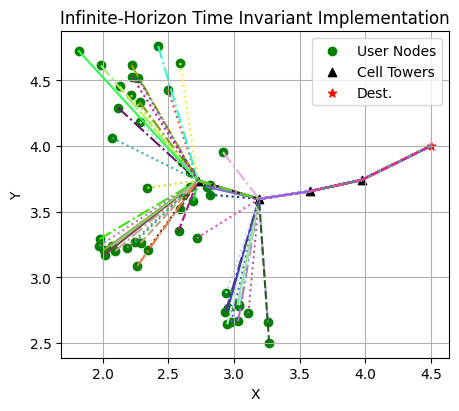

In [75]:
plotRoutes(smallcell1, finalPol, 'Infinite horizon FLPO')

In [76]:
finalPol[1:1+smallcell1.f*smallcell1.f]

array([[3.25089938e-023, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        1.23364712e-011, 1.00000000e+000, 1.68799492e-058,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [1.14202414e-061, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 1.00000000e+000,
        0.00000000e+000, 5.24254141e-020, 1.74852748e-030,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 1.08007565e-016,
        6.98533105e-047, 0.00000000e+000, 7.24167253e-110,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00

# Model-free Reinforcement Learning with MEP

## Tabular Q-Learning With MEP

Now we try and implement the Model-free reinforcement learning algorithm with MEP as mentioned in algorithm 1 in Amber's paper. We carry out Q-learning with MEP to asynchronously estimate the optimal Q function for the model while maximizing MEP. The Q function estimate is updated using hte following update rule.

$ \lambda_{k+1}(s, a) = (1-\epsilon_{k})\lambda_{k}(s,a) + \epsilon_{k}\left( c_{ss'}^{a} -\frac{\gamma^{2}}{\beta}log\left[ \sum\limits_{a' \in\mathscr{A_{s}}} exp\left\lbrace \frac{-\beta}{\gamma} \lambda_{k}(s', a') \right\rbrace \right] \right) $, $(s, a) = (s_{k}, a_{k}), s' = s_{k+1}$

$\lambda_{k+1}(s, a) = \lambda_{k}(s, a)$

With action masks $M(s, a)$, the above update rule can be modified as follows...
 
$ \lambda_{k+1}(s, a) = (1-\epsilon_{k})\lambda_{k}(s,a) + \epsilon_{k}\left( c_{ss'}^{a} -\frac{\gamma^{2}}{\beta}log\left[ \sum\limits_{a' \in\mathscr{A}} M(s, a) exp\left\lbrace \frac{-\beta}{\gamma} \lambda_{k}(s', a') \right\rbrace \right] \right) $, $(s, a) = (s_{k}, a_{k}), s' = s_{k+1} $

$\lambda_{k+1}(s, a) = \lambda_{k}(s, a)$



In [483]:
def Q_learn_MEP(model:SmallCellNet, initValue:np.ndarray, initPolicy:np.ndarray, beta_init=0.001, beta_grow= 1e-6, gamma = 0.95, max_iters=10000000, eps=lambda x: 0.05, eg=lambda x:0.95**(x-1), max_episdoes = 1):
    '''
    initPolicy: state_space x action_space tensor representing the intial policy forQ-Learning 
    eps: lambda function for scheduled learning rate w.r.t iterations
    eg: lambda function for scheduled exploration/exploitation greedyness w.r.t iterations
    return:
    Q_estim: The optimized estimate of the Q-function
    out_params: Disctionary of parameters for analysis of training process
    '''

    #check the dimensions of the initial policy..
    assert(initPolicy.shape == (*model.state_space_shape(), *model.act_space_shape()));
    assert(initValue.shape == (*model.state_space_shape(), *model.act_space_shape()))
    
    #start with the initialization of the Q-function to all zeros
    Q_estim = initValue.copy();
    visits = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()));
    action_mask = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape())); #well make up the action mask as we go along..
    finalPol = initPolicy.copy();
    out_params = {};
    Q_norm_array = [];
    beta = beta_init;
    
    #carry out some number of steps along the policy..
    for it in range(max_episdoes): #loop for number of episodes(1 implies single state-space trajectory)
        #start with the initial state and set the model state to that state
        isi = np.random.choice(np.arange(len(model.state_space)));
        init_state = model.state_space[isi];
        model.setState(*init_state);
        # print(f'initialization No: {it}, State: {s}');
        for i in range(max_iters):
            eggs = eg(i+1);
            #first...randomly select a policy according to the action..
            #get the actions..
            # eps = 1/((10000*it) + i +1);
            Q_prev = Q_estim.copy();
            
            state = model.state();
            acts = model.get_actions();
            action_mask[state, acts]=1; #enable the actions for the state...
            
            #just carry out housekeeping to clear out any probability related to prohibited actions during first visit on a state
            if(np.sum(visits[state]) == 0):
                divsr = np.sum(action_mask[state]);
                # divsr[divsr==0] = len(model.action_space); # for states that are unvisited yet i.e the action mask is all zeros, have a uniformly random policy
                resProb = np.sum((1-action_mask[state])*finalPol[state])/divsr;

                finalPol[state] = action_mask[state] * (finalPol[state] + resProb);

            #now we implement the epsilon greedy strategy for selection of action
            #first determine whether to explore or exploit..
            if(np.random.choice([0, 1], p=[eggs, 1-eggs]) <=0.5):
                #explore!! randomly from the avaiable actions
                acti = np.random.choice(range(len(acts))); #choose one from the actions with equal probability..
                act = acts[acti]
            else:
                #exploit...using the latest updated policy...
                acti = np.random.choice(range(len(model.action_space)), p= list(np.ravel(finalPol[state])));
                act = model.action_space[acti];

            epps = eps(visits[(*state, *act)]+1);
            #now carry out the action on the system and get the reward and, befire that, save the reference of the present state of the model
            #now execute the action and jumpt to the next state getting the reward,
            cost= model.step_and_exec(*act);
            # print(Q_estim[(*gpuq.state(), 1)]);
            #with the instantaneous reward and the present state of the Q function.....updte the Q function eatimate..
            # Q_estim[(*state, act)] -= epps * (Q_estim[(*state, act)] - reward - gamma*max(Q_estim[(*model.state(), 0)], Q_estim[(*model.state(), 1)]));
            
            #update the Q-function estimate using the bellman operator estimate....
            acts_new = model.get_actions(); #get actions at the next state...for summation over them
            expo_ns = [np.exp((-beta/gamma)*Q_estim[(*model.state(), *act)]) for act in acts_new];
            expo_sum = sum(expo_ns);
            Q_estim[(*state, *act)] -= epps * ( Q_estim[(*state, *act)] - cost + ((gamma**2)/beta)*np.log(expo_sum) );

            #once the Q_estimate is updated....update the policy using the updated Q estimate
            expo_s = np.exp((-beta/gamma) * (Q_estim[state] - np.min(Q_estim[state])))*action_mask[state] ;#exponent of the q-function to get the final policy...
            sumexpo_s = np.sum(expo_s);
            finalPol[state] = expo_s/sumexpo_s;
            
            visits[(*state, *act)] +=1;
            Q_norm_array.append(np.max(np.abs(Q_estim)));
            if(i%200000 == 0):
                print(f"episode = {it}, i={i}: ({state}, {act}, {cost} -> {model.state()}), Q: {Q_estim[(*model.state(), act)]}, Q_norm: {Q_norm_array[-1]}", end='\r'); #Q_prev
            
            #break is model state is zero...i.e it has reached termination
            if(model.state() == (0,)): ##for mow only for the small cell model...
                break;

            # print(state_next);
            #now set the state to the next state..
            # model.setState(*state_next);
            # print(gpuq.state());
        
        #update beta before next episode
        beta += beta_grow;
    
    out_params = {'visits': visits, 'Q_norm_array': Q_norm_array, 'action_mask': action_mask};
    #finally return the optimal Q function value..
    return [Q_estim, finalPol, out_params];

### Model-free RL for Small Cell Net Model

In [484]:
smallcell1 = SmallCellNet('smallCellNetData.pkl');
print(smallcell1.state())
smallcell1.setState(1)
print(smallcell1.cellLocations[3])
print(smallcell1.step(0))

(0,)
[0. 0.]


AttributeError: 'SmallCellNet' object has no attribute 'step'

In [ ]:
initPolicy = np.ones(shape = (*smallcell1.state_space_shape(), *smallcell1.act_space_shape()))/len(smallcell1.action_space);
initQ_estim = np.zeros(shape = (*smallcell1.state_space_shape(), *smallcell1.act_space_shape()))
beta_array = [0.001011]; # [0.1, 1, 2, 4, 8, 10];
eps = lambda x: (1/x)**0.8; ##learning rate
for bet in beta_array:
    st = time.time();
    [finalVal, finalPol, train_params] = Q_learn_MEP(smallcell1, initQ_estim, initPolicy, beta_init = bet, beta_grow=0, gamma=0.9, max_iters=10000000,eps=eps, max_episdoes=1000000);
    # QIteration(smallcell1, initPolicy, state_space=state_space, action_space=act_space,gamma=0.9, beta=bet, n_iters=201, allow_print=True, reward2cost=1);
    print(f'\nExecution Time: {time.time() - st} seconds');
    pol_det = (finalPol > 0.5)*1; #make the NPG policy deterministic by determining action as 1 if the probability is greater than 1
    # plotResults(pol_det, title=f'Final Policy, $\\beta$ = {bet}');

episode = 999999, i=0: ((47,), (2,), 97.58989070454174 -> (2,)), Q: [0.], Q_norm: 5353.08272006375885
Execution Time: 554.6147298812866 seconds


In [ ]:
train_params['visits']

array([[ 19154.,      0.,      0.,      0.,      0.,      0.],
       [118097.,      0., 151681., 150786., 151185., 151069.],
       [118108., 151354.,      0., 151335., 151283., 151377.],
       [117829., 151179., 151539.,      0., 150746., 150264.],
       [118113., 151453., 151442., 150273.,      0., 150828.],
       [118049., 151036., 150908., 151093., 150942.,      0.],
       [     0.,   3769.,   3792.,   3759.,   3864.,   3865.],
       [     0.,   3944.,   3806.,   3830.,   3810.,   3905.],
       [     0.,   3802.,   3766.,   3810.,   3951.,   3841.],
       [     0.,   3961.,   3849.,   3875.,   3805.,   3844.],
       [     0.,   3810.,   3918.,   3777.,   3824.,   3897.],
       [     0.,   3828.,   3824.,   3777.,   3820.,   3893.],
       [     0.,   3837.,   3840.,   3922.,   3907.,   3938.],
       [     0.,   3908.,   3731.,   3749.,   3883.,   3770.],
       [     0.,   3905.,   3820.,   3937.,   3814.,   3883.],
       [     0.,   3929.,   3829.,   3855.,   3904.,   

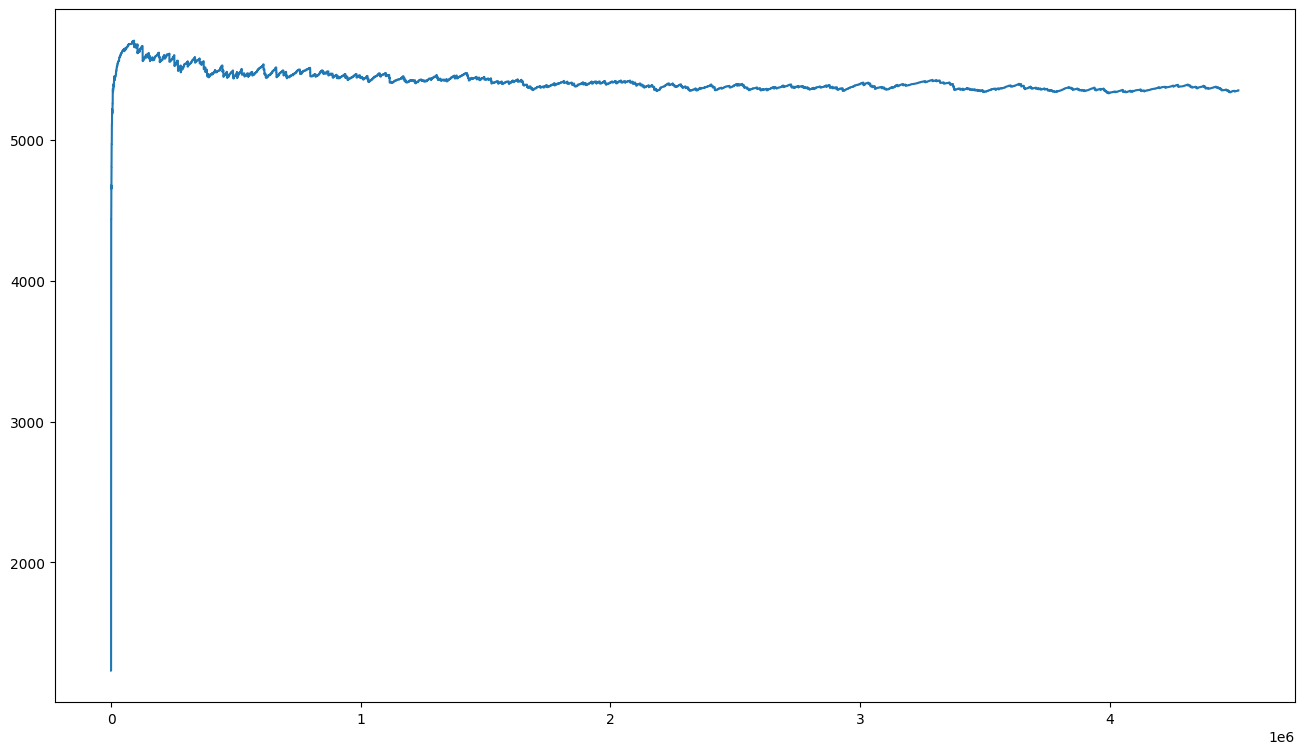

In [ ]:
plt.figure(figsize= (16, 9));
plt.plot(train_params['Q_norm_array']);

In [ ]:
finalPol

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [6.78154469e-04, 0.00000000e+00, 2.50262101e-01, 2.47204723e-01,
        2.51020062e-01, 2.50834959e-01],
       [6.76365379e-04, 2.49353229e-01, 0.00000000e+00, 2.54564741e-01,
        2.47636159e-01, 2.47769506e-01],
       [6.69680416e-04, 2.54135705e-01, 2.45208775e-01, 0.00000000e+00,
        2.50385964e-01, 2.49599875e-01],
       [6.68446832e-04, 2.47571399e-01, 2.52308396e-01, 2.51708876e-01,
        0.00000000e+00, 2.47742883e-01],
       [6.71183267e-04, 2.47119854e-01, 2.54197950e-01, 2.49609851e-01,
        2.48401161e-01, 0.00000000e+00],
       [0.00000000e+00, 1.91585076e-01, 2.05456542e-01, 1.79933146e-01,
        2.04443921e-01, 2.18581316e-01],
       [0.00000000e+00, 1.91172608e-01, 1.87418649e-01, 1.93083981e-01,
        2.17588458e-01, 2.10736304e-01],
       [0.00000000e+00, 1.98076442e-01, 1.93635483e-01, 2.01679663e-01,
        2.08092968e-01, 

#### Now trying the same reinforcement learning at beta=4

Using the optimal parameters from the model at beta 4 solved using paraMDP, try to use model-free RL to get the optimal policy and compare against the paraMDP result

In [ ]:
smallcell1 = SmallCellNet('smallCellNetData.pkl');
print(smallcell1.state())
smallcell1.setState(1)
print(smallcell1.cellLocations[3])
print(smallcell1.step(0))

(0,)
[0. 0.]
[[(0,), 14.999999999999986, 0.9, [-8.0, -14.0, 0, 0, 0, 0, 0, 0, 0, 0]], [(0,), 14.999999999999986, 0.1, [-8.0, -14.0, 0, 0, 0, 0, 0, 0, 0, 0]]]


In [ ]:
smallcell1.update_params(params= np.array([4.02035203, 5.01454284, 4.0522047 , 3.06773684, 6.06056285,
5.52820043, 7.55370813, 3.72120812, 2.82921549, 4.88528902]));
smallcell1.update_cost_matrix();
smallcell1.update_grad_matrix();
smallcell1.parameters()

array([4.02035203, 5.01454284, 4.0522047 , 3.06773684, 6.06056285,
       5.52820043, 7.55370813, 3.72120812, 2.82921549, 4.88528902])

In [ ]:
initPolicy = np.ones(shape = (*smallcell1.state_space_shape(), *smallcell1.act_space_shape()))/len(smallcell1.action_space);
initQ_estim = np.zeros(shape = (*smallcell1.state_space_shape(), *smallcell1.act_space_shape()))
beta_array = [0.001]; # [0.1, 1, 2, 4, 8, 10];
eps = lambda x: (1/x)**0.8; ##learning rate
for bet in beta_array:
    st = time.time();
    [finalVal, finalPol, train_params] = Q_learn_MEP(smallcell1, initQ_estim, initPolicy, beta_init= bet, beta_grow=4e-6, gamma=0.9, max_iters=10000000, eps= eps, max_episdoes=1000000);
    # QIteration(smallcell1, initPolicy, state_space=state_space, action_space=act_space,gamma=0.9, beta=bet, n_iters=201, allow_print=True, reward2cost=1);
    print(f'\nExecution Time: {time.time() - st} seconds');
    pol_det = (finalPol > 0.5)*1; #make the NPG policy deterministic by determining action as 1 if the probability is greater than 1
    # plotResults(pol_det, title=f'Final Policy, $\\beta$ = {bet}');

episode = 999999, i=0: ((7,), (5,), 6.161289654998661 -> (5,)), Q: [0.], Q_norm: 46.05754566067961515
Execution Time: 478.9173903465271 seconds


In [ ]:
train_params['visits']

array([[ 19154.,      0.,      0.,      0.,      0.,      0.],
       [166249.,      0., 112698., 110550., 106135., 118291.],
       [ 96883., 157485.,      0.,  99774.,  98073., 106179.],
       [163948., 114629., 106858.,      0., 107584., 106670.],
       [ 95175.,  99055.,  98755., 157732.,      0.,  95643.],
       [148394., 113107., 103726., 100227.,  97638.,      0.],
       [     0.,   3862.,   3792.,   3912.,   3816.,   3792.],
       [     0.,   3784.,   3901.,   3776.,   3822.,   3886.],
       [     0.,   3720.,   3928.,   3771.,   3769.,   3950.],
       [     0.,   3869.,   3907.,   3755.,   3803.,   3867.],
       [     0.,   3863.,   3909.,   3915.,   3793.,   3831.],
       [     0.,   3858.,   3918.,   3809.,   3670.,   3931.],
       [     0.,   3884.,   3759.,   3849.,   3948.,   3811.],
       [     0.,   3959.,   3804.,   3762.,   3822.,   3862.],
       [     0.,   3785.,   3764.,   3988.,   3845.,   3884.],
       [     0.,   3823.,   3786.,   3757.,   3688.,   

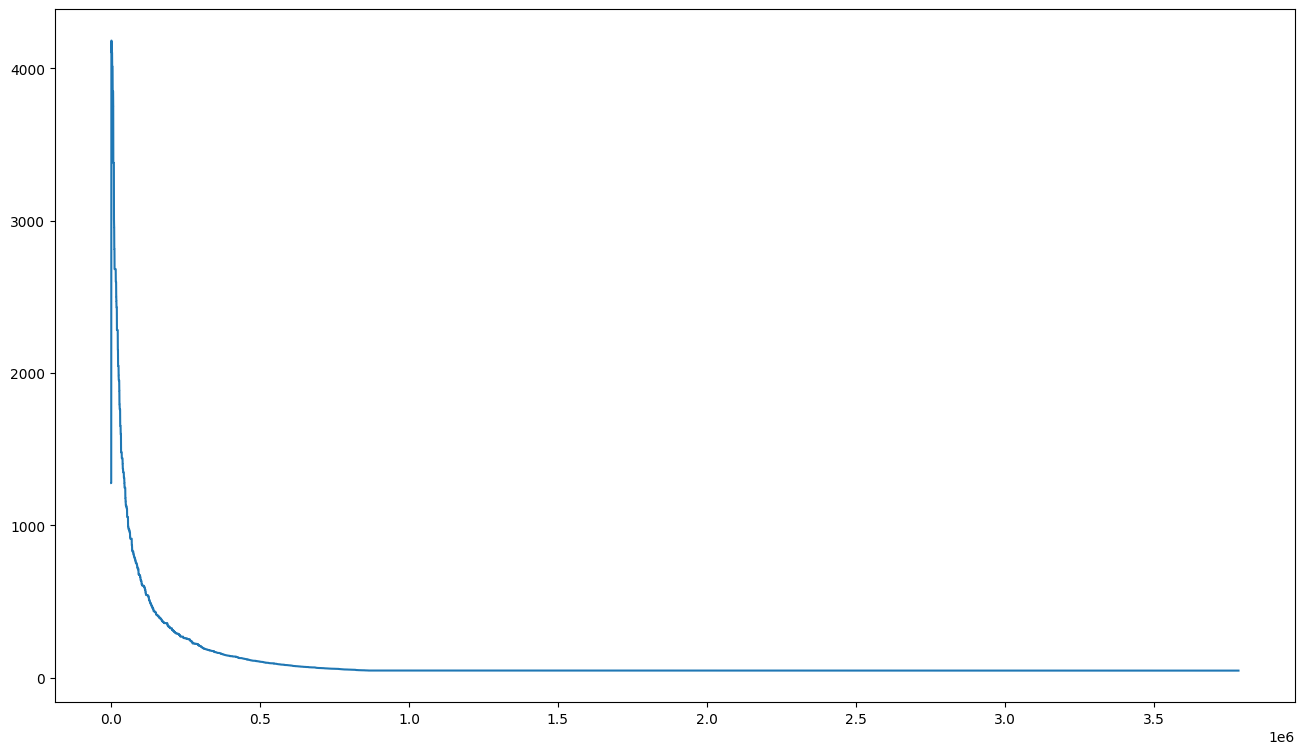

In [ ]:
plt.figure(figsize= (16, 9));
plt.plot(train_params['Q_norm_array']);

In [ ]:
finalPol[1:6]

array([[1.00000000e+00, 0.00000000e+00, 5.24329173e-29, 2.47761508e-20,
        8.51811112e-54, 3.31744212e-14],
       [3.73726670e-06, 9.99977108e-01, 0.00000000e+00, 1.61544787e-15,
        1.82022697e-36, 1.91547381e-05],
       [1.00000000e+00, 4.12171101e-12, 1.74369629e-35, 0.00000000e+00,
        2.04039193e-34, 2.25259243e-26],
       [4.23733794e-13, 6.28273020e-12, 5.59497746e-23, 1.00000000e+00,
        0.00000000e+00, 2.13902659e-31],
       [9.99999938e-01, 6.24246505e-08, 2.18333415e-27, 3.95952091e-28,
        1.22360370e-66, 0.00000000e+00]])

[4.02035203 5.01454284] -> [4. 7.]
[4.0522047  3.06773684] -> [4.02035203 5.01454284]
[6.06056285 5.52820043] -> [4. 7.]
[7.55370813 3.72120812] -> [6.06056285 5.52820043]
[2.82921549 4.88528902] -> [4. 7.]
[1.96016213 2.50033069] -> [2.82921549 4.88528902]
[1.65174273 2.70014656] -> [2.82921549 4.88528902]
[1.55698682 2.63460299] -> [2.82921549 4.88528902]
[1.28261786 2.66478511] -> [2.82921549 4.88528902]
[1.1771898  2.67959988] -> [2.82921549 4.88528902]
[1.62494626 2.92460785] -> [2.82921549 4.88528902]
[2.0310971 2.5923048] -> [2.82921549 4.88528902]
[2.71209664 0.88874371] -> [4.0522047  3.06773684]
[3.05451971 1.16122474] -> [4.0522047  3.06773684]
[3.49045589 0.9008766 ] -> [4.0522047  3.06773684]
[2.90899115 0.75996149] -> [4.0522047  3.06773684]
[3.42444062 0.66908677] -> [4.0522047  3.06773684]
[3.13825258 1.03462334] -> [4.0522047  3.06773684]
[3.13331089 0.87185227] -> [4.0522047  3.06773684]
[2.86878137 1.07095336] -> [4.0522047  3.06773684]
[2.43357979 0.88022862] -> [4.

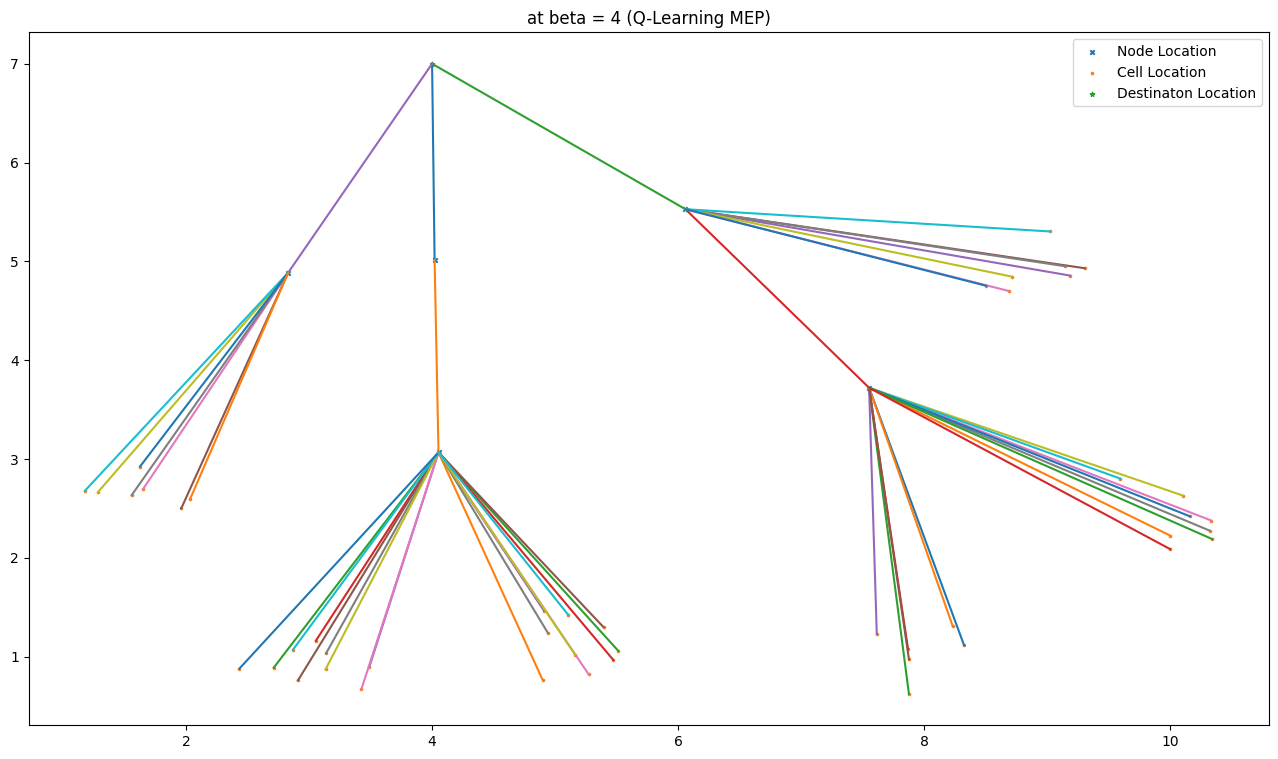

In [ ]:
plotPolicy(smallcell1, finalPol, 'at beta = 4 (Q-Learning MEP)', plotNodes=True);

## Model-free Learning of G-function

We implement a Model-free RL algorithm to estimate the fixed point of the gradient w.r.t parameters using state-action-cost trajectory data from the mode. The (s, a, c, s') tuples are an unbiased estimate for the following bellman operator

$\left[TK_{\eta}^{\beta}\right](s, a) = \sum\limits_{s'} p_{ss'}^{a} \left[ \frac{\partial c_{ss'}^{a}}{\partial \eta} + \gamma G_{\eta}^{\beta}(s') \right]$

$ G_{\eta}^{\beta}(s) =  \sum\limits_{a \in \mathscr{A}} \mu(a|s) K_{\eta}^{\beta}(s,a) $

The unbiased estimate of the gradient of cost w.r.t parameters $\frac{\partial c_{ss'}^{a}}{\partial \eta}$ is obtained by obtaining and comparing cost for $(s, a) \rightarrow s'$ trainsition between two models, one with the original parameter $\eta$ and another with a perturbed parameter $\eta' := \eta + \delta\eta$ as follows

$\frac{\partial c_{ss'}^{a}}{\partial \eta} \approx \frac{c_{\eta, ss'}^{a}- c_{\eta', ss'}^{a}}{\delta\eta}$

Thus we have the update rule as follows

- for each parameter $\eta$
    - $ K_{\eta,k+1}^{\beta}(s, a) = (1-\epsilon_{k})K_{\eta,k}^{\beta}(s,a) + \epsilon_{k}\left( \frac{\partial c_{ss'}^{a}}{\partial\eta} +\gamma G_{\eta, k}^{\beta}(s') \right) $, $(s, a) = (s_{k}, a_{k}), s' = s_{k+1}$

    - $K_{\eta,k+1}^{\beta}(s, a) = K_{\eta,k}^{\beta}(s, a)$

    - $G_{\eta, k+1}^{\beta}(s) =  \sum\limits_{a \in \mathscr{A}} \mu(a|s) K_{\eta, k+1}^{\beta}(s,a)$

In [ ]:
def G_learn_MEP(model:SmallCellNet, initValue:np.ndarray, policy:np.ndarray, beta, gamma = 0.95, deltaParam=0.001, max_iters=10000000, eps=lambda x: 0.05, max_episdoes = 1):
    '''
    initValue: Initial assumption of the state-action-parameter K-function
    Policy: state_space x action_space tensor representing the intial policy forQ-Learning 
    eps: lambda function for scheduled learning rate w.r.t iterations
    return:
    Q_estim: The optimized estimate of the state-action-parameter K-function
    G_estim: the optimized estimate of the state-parameter G-function
    out_params: Disctionary of parameters for analysis of training process
    '''

    #check the dimensions of the initial policy..
    assert(initPolicy.shape == (*model.state_space_shape(), *model.act_space_shape()));
    assert(initValue.shape == (*model.state_space_shape(), *model.act_space_shape(), model.parameters().shape[0]))
    
    #start with the initialization of the Q-function to all zeros
    Q_estim = initValue.copy();
    s = len(model.state_space_shape());
    sa = len(model.state_space_shape()) + len(model.act_space_shape());
    G_estim = np.expand_dims(policy, axis=-1) * Q_estim;
    #finally summup over the possible actions...
    G_estim = np.sum(G_estim, axis= tuple(np.arange(s, sa)));
    visits = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()));
    action_mask = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape())); #well make up the action mask as we go along..
    out_params = {};
    Q_norm_array = [];
    
    #carry out some number of steps along the policy..
    for it in range(max_episdoes): #loop for number of episodes(1 implies single state-space trajectory)
        #start with the initial state and set the model state to that state
        isi = np.random.choice(np.arange(len(model.state_space)));
        init_state = model.state_space[isi];
        model.setState(*init_state);
        # print(f'initialization No: {it}, State: {s}');
        for i in range(max_iters):
            #first...randomly select a policy according to the action..
            #get the actions..
            # eps = 1/((10000*it) + i +1);
            Q_prev = Q_estim.copy();
            
            state = model.state();
            acts = model.get_actions();
            action_mask[state, acts]=1; #enable the actions for the state...
            
            #just carry out housekeeping to crear out any probability related to prohibited actions during first visit on a state
            if(np.sum(visits[state]) == 0):
                divsr = np.sum(action_mask[state]);
                # divsr[divsr==0] = len(model.action_space); # for states that are unvisited yet i.e the action mask is all zeros, have a uniformly random policy
                resProb = np.sum((1-action_mask[state])*policy[state])/divsr;

                policy[state] = action_mask[state] * (policy[state] + resProb);

            #now we implement the epsilon greedy strategy for selection of action
            #first determine whether to explore or exploit..
            #sample action from the policy...
            acti = np.random.choice(range(len(model.action_space)), p= list(np.ravel(policy[state])));
            act = model.action_space[acti];
            epps = eps(visits[(*state, *act)]+1);

            #now before executing the action on the mdoel, make a copy of the model for each of the model parameters
            modelcopies = [copy.deepcopy(model) for p in model.parameters()]

            #now carry out the action on thte system and get the reward and, befire that, save the reference of the present state of the model
            #now execute the action and jumpt to the next state getting the reward,
            cost= model.step_and_exec(*act);
            
            
            #Now, perturb the parameters in each of the model copies along one of the standard basis by set perturbation
            perturbation = np.eye(model.parameters().shape[0],model.parameters().shape[0])*deltaParam;
            #now apply it to each of the model parameters in the copies
            for pi in range(model.parameters().shape[0]):
                #update corresponding modelcopy
                modelcopies[pi].update_params( modelcopies[pi].parameters() + perturbation[pi] );

                #now execute the step according to the specified action...but ensuring that the reulting state of the original model
                # is attained and get the modified cost
                cost_pi = modelcopies[pi].step_and_exec(*act, deterministic_state= model.state());

                #the cost gradient w.r.t parameter is thus
                cg = (cost_pi - cost) / deltaParam;

                #update the Q estimate
                Q_estim[(*state, *act, pi)] -= epps * ( Q_estim[(*state, *act, pi)] - cg - (gamma)*G_estim[(*model.state(), pi)] );
                #update the G_estimate for the state-parameter by taking expectation over policy
                G_estim[(*state, pi)] = np.sum( policy[state] * Q_estim[(*state, ..., pi)] );
            
            visits[(*state, *act)] +=1;
            Q_norm_array.append(np.max(np.abs(Q_estim)));
            if(i%200000 == 0):
                print(f"episode = {it}, i={i}: ({state}, {act}, {cost} -> {model.state()}), Q: {Q_estim[(*model.state(), act)]}, Q_norm: {Q_norm_array[-1]}", end='\r'); #Q_prev
            
            #break is model state is zero...i.e it has reached termination
            if(model.state() == (0,)): ##for mow only for the small cell model...
                break;

            # print(state_next);
            #now set the state to the next state..
            # model.setState(*state_next);
            # print(gpuq.state());
        
    
    out_params = {'visits': visits, 'Q_norm_array': Q_norm_array, 'action_mask': action_mask};
    #finally return the optimal Q function value..
    return [Q_estim, G_estim, out_params];

## Model-free Parameter update via gradient decent

Now we define a routine to optimize the paramaters via gradient decent in a model-free setting using G-learning

The parameters are optimized using gradient decent where the gradient w.r.t parameters is obtained as the the estimated fixed point solution by model-free GLearning for the latest updated value of the parameters. Hence the algorithm of determning the optimal parameters for the given policy consists of the following steps:

Until Convergence

1. for parameter estimates $\eta_{k}$ and given policy, estimate the fixed point of the gradient bellman equation $G_{\eta_{k}}^{\beta}$ using G_learn_MEP

2. Update parameter values using gradient descent

$ \eta_{k+1} = \eta_{k} - \epsilon_{k} \sum\limits_{s\in\mathscr{S}} G_{\eta_{k}}^{\beta}(s) $

3. $k \leftarrow k+1$

In [ ]:
#define parameter gradient descent optimization routine here
def optimizeParams_RL(model:SmallCellNet, initValue:np.ndarray, policy:np.ndarray, gamma:float, beta:float, epsilon:float, epsg:lambda x:0.005, n_iters:int, n_episodes:int, gd_iters:int, allow_print = True, reward2cost:int=-1) -> dict:

    '''
    Function performs gradient descent optimization for the parameters of the model for a fixed policy by determination of gradient fixed points
    params:
    model: The system model instance on whcih Q iteration is to be carried out.
    initValue: initial Assumption/estimate of the state-action-parameter K-function.
    policy: Policy (probabilistic) on which the fixed point of the gradient vector is to be determined
    gamma: Discount Factor for the rewards
    beta: entropy maximization weightage factor
    epsilon: learning rate for gradient descent
    epsg: lambda expression for learning rate for G-learning...
    n_iters: number of iterations of iteration steps on the model in one episode.
    n_episodes: number of episodes of G-learning on the model
    gd_iters: number of gradient descent iterations
    reward2cost: conversion factor for conversion of reward model to cost model (-1 for reward model, 1 for cost model) >Default = -1
    '''

    #firstly get the lis of model parameters and assert if there are model parameters to optimize
    assert(model.parameters().shape != (0,));
    assert(initValue.shape == (*model.state_space_shape(), *model.act_space_shape(), model.parameters().shape[0]));

    train_params = {};
    norm_diff = [];
    norm= [] 

    #now just start the gradient descent iterations
    s = len(model.state_space_shape());
    sa = len(model.state_space_shape()) + len(model.act_space_shape());
    K_prev = initValue;
    G_prev = np.expand_dims(policy, axis=-1) * K_prev;
    #finally summup over the possible actions...
    G_prev = np.sum(G_prev, axis= tuple(np.arange(s, sa)));
    for iter in range(gd_iters):

        #in each iteration, compute the fixed point of the gradient using GIteration for the present value of the parameters
        [K, G, _] = G_learn_MEP(model, K_prev, policy, beta, gamma,deltaParam=0.001, max_iters=n_iters, eps=epsg, max_episdoes=n_episodes)
        # [G, _]= GIteration(model, G_prev, policy, state_space, action_space, gamma, beta,
        # n_iters, False, reward2cost);

        #now once the gradient is obtained w.r.rt each parameter in the model..time to update the parameters of the model
        #get the list of parameters first
        params = model.parameters();

        #now loop through the model parameters and update the list elements individually
        params =  params - epsilon*np.sum(G, axis = tuple(np.arange(0,len(model.state_space_shape()))) );
        # params = np.array([ params[i] - epsilon*np.sum(G[..., i]) for i in range(params.shape[0])]);

        #finally update the parameters in the model
        model.update_params(params);

        #print the norms for reference
        norm_diff.append(np.max(abs(G - G_prev)));
        norm.append(np.max(abs(G)));
        G_prev = G.copy();
        K_prev = K.copy();
        if(allow_print):
            print(f'iter: {iter} \t Delta Value(infinity Norm): {norm_diff[-1]} \t Infinity Norm: {norm[-1]}', end='\r');
        
        #finally check condition for convergence of optimal Q function and stop iteration if met
        if( norm[-1] < 1e-2):
            #condition met
            if(allow_print):
                print(f'\nPolicy and Params:\tfor GD, {norm[-1]} < 1e-2, Hence stopping Gradient Descent Iteration');
            break;
    
    train_params['norm_diff'] = norm_diff;
    train_params['norm'] = norm;

    return [K, G, train_params];


## Model-free Policy+Paramater Optimization

Now, we define a routine to carry out policy and parameter optimization for the model in an alternating fashion, i.e we carry out the following steps

Until Convergence

1. Fixing the model parameters for a given $\beta$ determine the optimal policy using model-free Q-learning

2. Fixing the updated policy, optimize parameters using gradient descent in a model-free fashion.

In [ ]:
#define the policy and parameteroptimization routine here..
def optimizePolicyNParams_RL(model:SmallCellNet, initPolicy:np.ndarray, gamma:float, beta:float, epsilon:float, n_iters:int, n_iters_qi:int, n_episodes_qi:int, gd_iters:int, n_iters_gi:int, n_episodes_gi:int, eps=lambda x: 0.05, egs=lambda x:0.95**(x-1), allow_print = True, reward2cost:int=-1, aux_params:dict=None):
    '''
    function to optimize the poliy and parameters via alternating Q_learn_MEP and parameter optimization via G_learn_MEP
    params:
    model: The system model instance on whcih Q_learn and parameter optimization is to be carried out.
    initPolicy: initial policy for learning Q-function
    gamma: Discount Factor for the rewards
    beta: entropy maximization weightage factor
    epsilon: learning rate for gradient descent
    eps: learning rate for estimation of Q and G-function fixed points
    egs: epsilon-greedy exploration probability during policy Q-learning
    n_iters: number of iterations of policy+parameter optimization.
    n_iters_qi: number of time-step iterations of q-function fixed point determintation
    n_episodes_qi: number of q-learning episodes
    gd_iters: number of gradient descent iterations
    n_iters_gi: number of time-step iteration for fixed point estimation of G-function
    n_episodes_gi: number of g-learning episodes
    reward2cost: conversion factor for conversion of reward model to cost model (-1 for reward model, 1 for cost model) >Default = -1
    aux_params: auxiliary parameters as a dictionary
    return:
    finalPol: Optimal Policy
    train_params: training parameters for debugging
    '''

    train_params ={};
    norm_diff = [];
    norm = [];
    finalPol = initPolicy.copy();

    #go ahead and directly start the alternating optimization iterations
    if(aux_params != None):
        Q_prev = aux_params['Q'];
        V_KI = aux_params['K'];
    else:
        Q_prev = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()))
        # V_QI = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()));
        V_KI = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape(), model.parameters().shape[0]));
    
    for iter in range(n_iters):

        #for each iterations, firstly,  for the present model parametrs and the given beta..
        #to do so initialize the Q_iteration estimate
        [Q, finalPol, train_params_Q] = Q_learn_MEP(model, Q_prev, finalPol,
         beta_init = beta, beta_grow=0, gamma=gamma, max_iters=n_iters_qi,eps=eps, eg=egs, max_episdoes=n_episodes_qi);
        # QIteration(smallcell1, Q_prev, state_space=model.state_space, action_space=model.action_space,gamma=gamma, beta=beta, n_iters=n_iters_qi, allow_print=False, reward2cost=reward2cost);

        #with the optimal policy for given parameters and beta determined using QIteration, now we optimize parameters for the given polcy and beta
        [V_KI, _, train_params_Q] = optimizeParams_RL(model, V_KI, finalPol, gamma=gamma, beta=beta, epsilon=epsilon,
        epsg=eps, n_iters=n_iters_gi,n_episodes=n_episodes_gi, gd_iters=gd_iters, allow_print=False, reward2cost=1);
        # [V_GI, train_params_P] = optimizeParams(smallcell1, V_GI, finalPol, model.state_space, model.action_space, gamma=gamma, beta=beta, epsilon=epsilon,
        # n_iters = n_iters_gi, gd_iters= gd_iters, allow_print=False, reward2cost=reward2cost);

        norm_diff.append(np.max(abs(Q - Q_prev)));
        norm.append(np.max(abs(Q)));
        Q_prev = Q.copy();
        if(allow_print):
            print(f'iter: {iter} \t Delta Q Value(infinity Norm): {norm_diff[-1]} \t Q-Infinity Norm: {norm[-1]}', end='\r');
        
        #finally check condition for convergence of optimal Q function and stop iteration if met
        if( norm_diff[-1]/norm[-1] < 1e-5):
            #condition met
            if(allow_print):
                print(f'\nPolicy and Params:\tfor Q, {norm_diff[-1]/norm[-1]} < 1e-10, Hence stopping Iteration');
            break;
        
    #finally return the optimal converged policy and the training parameters, optimized model parameters have already been updated on the model
    train_params['norm_diff'] = norm_diff;
    train_params['norm'] = norm;
    train_params['Q'] = Q;
    train_params['K'] = V_KI;

    return [finalPol, train_params];


## Model-free Annealed Policy+Parameter Optimization

We now define the routine to optimize the policy with parameters while annealing the inverse temperature beta

The algorithm is as follows;

1. initialize $\beta : = \beta_{init}$

2. while $\beta < \beta_{max}$

    a. Model-free optimize policy and parameters for $\beta$.

    b. $\beta \leftarrow \beta \times $ factor, where factor $> 1$.


In [ ]:
##define a routine for annealed optimization here
def optimizePolicyNParams_annealed_RL(model:SmallCellNet, initPolicy:np.ndarray, gamma:float, beta_init:float, beta_max:float, beta_grow:float, epsilon:float, n_iters:int, n_iters_qi:int, n_episodes_qi:int, gd_iters:int, n_iters_gi:int, n_episodes_gi:int, eps=lambda x: 0.05, egs=lambda x:0.95**(x-1), allow_print = True, reward2cost:int=-1):
    '''
    function to optimize the poliy and parameters via alternating Q_learn_MEP and parameter optimization via G_learn_MEP
    params:
    model: The system model instance on whcih Q_learn and parameter optimization is to be carried out.
    initPolicy: initial policy for learning Q-function
    gamma: Discount Factor for the rewards
    beta_init: entropy maximization weightage factor
    beta_max: maximum extropy regularization weight
    beta_grow: multiplicative growth-rate for beta
    epsilon: learning rate for gradient descent
    eps: learning rate for estimation of Q and G-function fixed points
    egs: epsilon-greedy exploration probability during policy Q-learning
    n_iters: number of iterations of policy+parameter optimization.
    n_iters_qi: number of time-step iterations of q-function fixed point determintation
    n_episodes_qi: number of q-learning episodes
    gd_iters: number of gradient descent iterations
    n_iters_gi: number of time-step iteration for fixed point estimation of G-function
    n_episodes_gi: number of g-learning episodes
    reward2cost: conversion factor for conversion of reward model to cost model (-1 for reward model, 1 for cost model) >Default = -1
    return:
    finalPol: Optimal Policy
    '''

    #direstly go ahead and start the iterations
    beta = beta_init; #initilize annealing temperature to initial value
    #start the iterations
    Q = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()))
    # V_QI = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()));
    K = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape(), model.parameters().shape[0]));
    finalPol = initPolicy.copy();

    while beta < beta_max:

        if(allow_print):
            print(f'@beta = {beta}');

        #determine the optimal policy and parameters for the given beta
        [finalPol, train_params] = optimizePolicyNParams_RL(model, finalPol,gamma=gamma, beta=beta, epsilon=epsilon,n_iters=n_iters,
        n_iters_qi=n_iters_qi,n_episodes_qi=n_episodes_qi,gd_iters=gd_iters,n_iters_gi=n_iters_gi,n_episodes_gi=n_episodes_gi,
        eps=eps,egs=egs,allow_print=True,reward2cost=1,aux_params={'Q': Q, 'K': K});
        # optimizePolicyNParams(model, gamma = gamma, beta = beta, epsilon=epsilon, n_iters=n_iters,
        # n_iters_qi=n_iters_qi, gd_iters=gd_iters, n_iters_gi=n_iters_gi, allow_print=allow_print, reward2cost=reward2cost,
        # aux_params={'Q': Q, 'K': K});

        Q = train_params['Q'];
        K = train_params['K'];

        #finally update the beta for next iteration
        beta = beta * beta_grow;
    
    #finally return the optimal policy
    return finalPol;

### Model-Free G-learning for Small Cell Net model

In [ ]:
smallcell1 = SmallCellNet('smallCellNetData.pkl');
print(smallcell1.state())
smallcell1.setState(1)
print(smallcell1.cellLocations[3])
print(smallcell1.step(0))
smallcell1.parameters();

(0,)
[0. 0.]
[[(0,), 14.999999999999986, 0.9, [-8.0, -14.0, 0, 0, 0, 0, 0, 0, 0, 0]], [(0,), 14.999999999999986, 0.1, [-8.0, -14.0, 0, 0, 0, 0, 0, 0, 0, 0]]]


Q-Learning to get the optimal Policy

In [ ]:
initPolicy = np.ones(shape = (*smallcell1.state_space_shape(), *smallcell1.act_space_shape()))/len(smallcell1.action_space);
initQ_estim = np.zeros(shape = (*smallcell1.state_space_shape(), *smallcell1.act_space_shape()))
beta_array = [0.001011]; # [0.1, 1, 2, 4, 8, 10];
eps = lambda x: (1/x)**0.8; ##learning rate
for bet in beta_array:
    st = time.time();
    [finalVal, finalPol, train_params] = Q_learn_MEP(smallcell1, initQ_estim, initPolicy, beta_init = bet, beta_grow=0, gamma=0.9, max_iters=10000000,eps=eps, max_episdoes=1000000);
    # QIteration(smallcell1, initPolicy, state_space=state_space, action_space=act_space,gamma=0.9, beta=bet, n_iters=201, allow_print=True, reward2cost=1);
    print(f'\nExecution Time: {time.time() - st} seconds');
    pol_det = (finalPol > 0.5)*1; #make the NPG policy deterministic by determining action as 1 if the probability is greater than 1
    # plotResults(pol_det, title=f'Final Policy, $\\beta$ = {bet}');

episode = 999999, i=0: ((1,), (5,), 0.0 -> (5,)), Q: [0.], Q_norm: 5348.439154432739348.4391544327395
Execution Time: 1162.2951216697693 seconds


G-Learning using the optimized policy to learn the fixed point of gradient

In [ ]:
initK_estim = np.zeros(shape = (*smallcell1.state_space_shape(), *smallcell1.act_space_shape(),smallcell1.parameters().shape[0]))
beta_array = [0.001011]; # [0.1, 1, 2, 4, 8, 10];
eps = lambda x: (1/x)**0.8; ##learning rate
for bet in beta_array:
    st = time.time();
    [finalKVal, finalGVal, train_params] = G_learn_MEP(smallcell1, initK_estim, finalPol, beta=bet, gamma=0.9, deltaParam=0.001, max_iters=10000000, eps=eps, max_episdoes=1000);
    # QIteration(smallcell1, initPolicy, state_space=state_space, action_space=act_space,gamma=0.9, beta=bet, n_iters=201, allow_print=True, reward2cost=1);
    print(f'\nExecution Time: {time.time() - st} seconds');
    pol_det = (finalPol > 0.5)*1; #make the NPG policy deterministic by determining action as 1 if the probability is greater than 1
    # plotResults(pol_det, title=f'Final Policy, $\\beta$ = {bet}');

episode = 999, i=0: ((2,), (3,), 0.0 -> (3,)), Q: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], Q_norm: 21.904388744376288.904388744376288
Execution Time: 120.12758231163025 seconds


In [ ]:
train_params['visits']

array([[ 15.,   0.,   0.,   0.,   0.,   0.],
       [  2.,   0., 422., 449., 434., 472.],
       [  0., 475.,   0., 483., 441., 457.],
       [  1., 431., 483.,   0., 431., 457.],
       [  1., 462., 458., 436.,   0., 443.],
       [  0., 434., 493., 428., 454.,   0.],
       [  0.,   3.,   5.,   5.,   7.,   4.],
       [  0.,   0.,   4.,   3.,   5.,   2.],
       [  0.,   3.,   4.,   2.,   4.,   6.],
       [  0.,   2.,   2.,   2.,   2.,   3.],
       [  0.,   3.,   5.,   6.,   4.,   3.],
       [  0.,   2.,   3.,   2.,   4.,   8.],
       [  0.,   3.,   6.,   6.,   2.,   6.],
       [  0.,   2.,   3.,   1.,   5.,   2.],
       [  0.,   4.,   4.,   3.,   7.,   1.],
       [  0.,   5.,   1.,   5.,   3.,   3.],
       [  0.,   1.,   3.,   7.,   3.,   1.],
       [  0.,   2.,   3.,   6.,   3.,   5.],
       [  0.,   3.,   2.,   2.,   9.,   3.],
       [  0.,   3.,   5.,   5.,   2.,   4.],
       [  0.,   3.,   1.,   3.,   8.,   3.],
       [  0.,   5.,   4.,   4.,   5.,   5.],
       [  

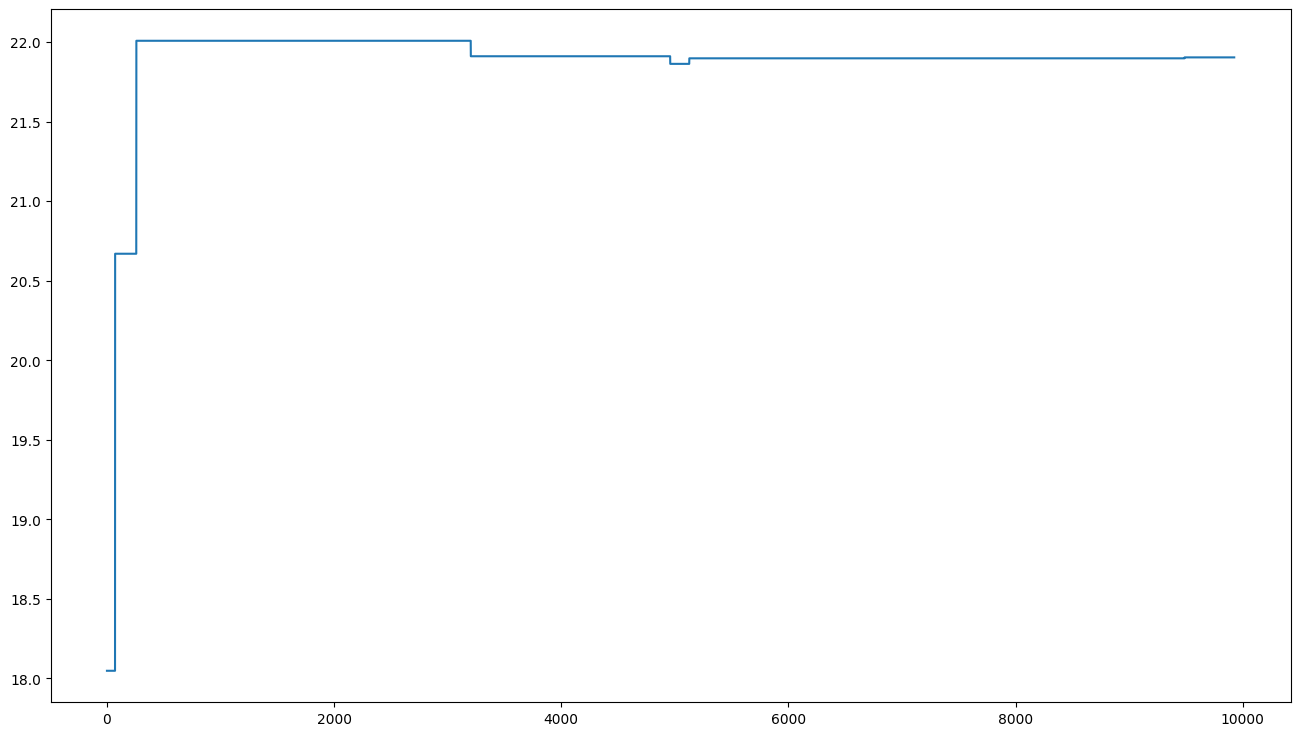

In [ ]:
plt.figure(figsize=(16,9));
plt.plot(train_params['Q_norm_array']);

In [ ]:
finalGVal[...,0]

array([ 0.        , -1.28002774, -0.59085268, -0.59921807, -0.60014405,
       -0.59097972, -1.40086679, -0.41634104, -1.09456885, -1.04265737,
       -1.04090369, -1.13901921, -1.33706485, -1.68556758, -1.85671542,
       -1.70122848, -1.60235856, -1.97686373, -1.82072059, -1.77958967,
       -1.69493844, -1.04384467, -2.51985974, -2.83636244, -2.74452054,
       -2.57480965, -2.60319164, -2.87017969, -2.67312057, -2.63291686,
       -2.36686917, -3.99084697, -0.36685097, -3.84213664, -3.7298279 ,
       -0.33718115, -3.76931051, -4.08919121, -4.90824094, -4.42466492,
       -4.15312495, -3.95295456, -4.26044539, -4.60209901, -4.55543352,
       -3.30526275, -4.23732798, -4.0268976 , -4.22284252, -3.83553693,
       -3.33962299, -3.3485826 ])

In [ ]:
np.sum(finalGVal, axis=0)

array([-127.41468353,  -85.24125002, -123.41949515,  -79.66304161,
       -132.67191559,  -93.27053357, -132.58432971,  -89.03409016,
       -124.56282203,  -82.28623661])

Optimize parameters in model-free setting via gradient descent

In [ ]:
smallcell1.init_params();
smallcell1.init_cost_matrix();
smallcell1.init_grad_matrix();
smallcell1.parameters()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
initK_estim = np.zeros(shape = (*smallcell1.state_space_shape(), *smallcell1.act_space_shape(),smallcell1.parameters().shape[0]))
beta = 0.001011; # [0.1, 1, 2, 4, 8, 10];
eps = lambda x: (1/x)**0.8; ##learning rate
st = time.time();
[finalKVal, finalGVal, train_params] = optimizeParams_RL(smallcell1, initK_estim, finalPol, gamma=0.9, beta=beta, epsilon=0.0001,
epsg=eps, n_iters=10000000,n_episodes=1000, gd_iters=200, allow_print=True, reward2cost=1);
print(f'\nExecution Time: {time.time() - st} seconds');

KeyboardInterrupt: 

In [ ]:
smallcell1.parameters()

array([1.09860119, 0.78887195, 1.09677472, 0.78987898, 1.09287795,
       0.78341629, 1.09689966, 0.78907275, 1.09152532, 0.78326308])

### Combined Model-free Policy+parameter optimization

Now try combined policy and parameter optimization on the smallCellNet model in a model-free setting.

In [ ]:
smallcell1.init_params();
smallcell1.init_cost_matrix();
smallcell1.init_grad_matrix();
smallcell1.parameters()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
initPolicy = np.ones(shape = (*smallcell1.state_space_shape(), *smallcell1.act_space_shape()))/len(smallcell1.action_space);
initQ_estim = np.zeros(shape = (*smallcell1.state_space_shape(), *smallcell1.act_space_shape()))
initK_estim = np.zeros(shape = (*smallcell1.state_space_shape(), *smallcell1.act_space_shape(),smallcell1.parameters().shape[0]))
aux_params = {'Q':initQ_estim, 'K':initK_estim};
beta = 0.001011; # [0.1, 1, 2, 4, 8, 10];
eps = lambda x: (1/x)**0.8; ##learning rate
egs = lambda x: 1;
st = time.time();
[finalPol, train_params] = optimizePolicyNParams_RL(smallcell1, initPolicy,gamma=0.9, beta=beta, epsilon=0.01,n_iters=10,
n_iters_qi=200,n_episodes_qi=1000,gd_iters=1,n_iters_gi=50,n_episodes_gi=500, eps=eps,egs=egs,allow_print=True,reward2cost=1,aux_params=aux_params);
print(f'\nExecution Time: {time.time() - st} seconds');

iter: 9 	 Delta Q Value(infinity Norm): 6857.047231529847 	 Q-Infinity Norm: 7311.2366321592450.]], Q_norm: 11.5504085745679444443
Execution Time: 576.6996574401855 seconds


In [ ]:
smallcell1.parameters()

array([5.09728106, 3.58989627, 5.04991856, 3.7535012 , 5.1069281 ,
       3.5931486 , 5.04608569, 3.57945474, 4.99149373, 3.65774626])

### Annealed Combined Model-free Policy+Parameter optimization
now we try optimizing policy and parameters for the model with annealing

In [ ]:
smallcell1.init_params();
smallcell1.init_cost_matrix();
smallcell1.init_grad_matrix();
smallcell1.parameters()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
initPolicy = np.ones(shape = (*smallcell1.state_space_shape(), *smallcell1.act_space_shape()))/len(smallcell1.action_space);
eps = lambda x: (1/x)**0.8; ##learning rate
egs = lambda x: 1;
st = time.time();
finalPol = optimizePolicyNParams_annealed_RL(smallcell1, initPolicy,gamma=0.9,beta_init=0.001011,beta_max=100,beta_grow=1.01,epsilon=0.01,n_iters=10,
n_iters_qi=200,n_episodes_qi=1000,gd_iters=1,n_iters_gi=50,n_episodes_gi=500, eps=eps,egs=egs,allow_print=True,reward2cost=1);
print(f'\nExecution Time: {time.time() - st} seconds');

@beta = 0.001011
@beta = 0.00102111Value(infinity Norm): 5565.658276813674 	 Q-Infinity Norm: 6845.6241214782995.]], Q_norm: 11.8382198711605522284
@beta = 0.0010313211lue(infinity Norm): 6396.152998271814 	 Q-Infinity Norm: 6815.272104202026 0.]], Q_norm: 9.9798883426683333992
@beta = 0.001041634311e(infinity Norm): 6297.574929784109 	 Q-Infinity Norm: 6778.06512672714. 0.]], Q_norm: 10.39057379215627279
@beta = 0.0010520506541100002ity Norm): 6333.468437516186 	 Q-Infinity Norm: 6543.964587424549 0.]], Q_norm: 10.128484683396314242
@beta = 0.0010625711606511003ity Norm): 4592.822436287346 	 Q-Infinity Norm: 6731.413734194242 0.]], Q_norm: 10.18051149298181666
@beta = 0.0010731968722576112ity Norm): 6519.65010698827 	 Q-Infinity Norm: 6940.646696573388. 0.]], Q_norm: 10.75584883318744442
@beta = 0.0010839288409801872ity Norm): 6243.070327750955 	 Q-Infinity Norm: 6869.592418407252 0.]], Q_norm: 10.214024955339486883
@beta = 0.001094768129389989nity Norm): 5941.242276610122 	 Q-Infinit

KeyboardInterrupt: 